Project: Augustana College Transaction Dataset 2021: Abnormailty Detection

# Data Understanding

Import Data and Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
df = pd.read_csv('/gdrive/My Drive/DATA 490 SI/Individual Project/2021 Transaction Dataset CSV.csv')

Data Description

In [4]:
df

Output hidden; open in https://colab.research.google.com to view.

In [5]:
df.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT  \
count        18311.000000            18311.000000   
mean          1177.135383                4.578885   
std            106.892244             7090.218600   
min           1001.000000          -357272.160000   
25%           1078.000000               20.000000   
50%           1158.000000               55.580000   
75%           1278.000000              174.000000   
max           1358.000000            13665.100000   

       FIN.ACCOUNTING CODE 05 VALUE  
count                  18291.000000  
mean                   61777.872068  
std                     6210.383484  
min                    12000.000000  
25%                    61500.000000  
50%                    62000.000000  
75%                    62107.000000  
max                    90502.000000

Columns

In [6]:
df.columns.values

array(['Account (cleansed)', 'Name (Cleansed)', 'FIN.POSTING DATE',
       'MCH.MERCHANT NAME', 'MCH.MCC DESCRIPTION',
       'FIN.TRANSACTION AMOUNT', 'FIN.TAX.TAX AMOUNT',
       'FIN.ACCOUNTING CODE 03 DESCRIPTION',
       'FIN.ACCOUNTING CODE 05 VALUE', 'MCH.ADDRESS', 'MCH.CITY NAME',
       'MCH.COUNTRY CODE', 'MCH.STATE / PROVINCE',
       'MCH.MERCHANT POSTAL CODE',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1',
       'ACC.ACCOUNT STATUS DESCRIPTION', 'FIN.TRANSACTION DATE',
       'Employee ID (cleansed)'], dtype=object)

Interpreted Column Meanings

|Feature| Question|
|:-:|:---|
|Account (cleansed)| Account (linked to Name and Employee ID)
|Name (Cleansed)| Name who used card (linked to Account and ID)
|FIN.POSTING DATE| Posting date of charge
|MCH.MERCHANT NAME| Name of the seller
|MCH.MCC DESCRIPTION| Seller description (category assigned by Augustana)
|FIN.TRANSACTION AMOUNT| Final transaction amount
|FIN.TAX.TAX AMOUNT| Total tax on purchase
|FIN.ACCOUNTING CODE 03 DESCRIPTION| Accounting code 03
|FIN.ACCOUNTING CODE 05 VALUE| Accounting code 05
|MCH.ADDRESS| Address of seller
|MCH.CITY NAME| City of seller
|MCH.COUNTRY CODE| Country code of seller (3 letter string)
|MCH.STATE / PROVINCE| State of seller (2 letter string if US, 3 elsewhere)
|MCH.MERCHANT POSTAL CODE| Seller postal code
|ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1| Department charged
|ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1| Who department answers to
|ACC.ACCOUNT STATUS DESCRIPTION| Active, Closed, Lost/Stolen
|FIN.TRANSACTION DATE| Dte charged to account (when transaction took place)
|EMPLOYEE ID (Cleansed)| Unique ID of the employee (linked to name and account)


Initial Dropping Columns

In [7]:
def drop_other_cols(df_change, labels):
    df_change.drop(labels = labels, inplace = True, axis = 1)
    return df_change

In [8]:
# drop accounting rows and mch address
columnsToDrop = ['FIN.TAX.TAX AMOUNT', 'FIN.ACCOUNTING CODE 03 DESCRIPTION', 'FIN.ACCOUNTING CODE 05 VALUE', 'MCH.ADDRESS']
df = drop_other_cols(df, columnsToDrop)

Find matched columns

In [9]:
# see difference between Account, Name, and Employee ID (cleansed)
df_testColumns = df.copy()
testLabels = ['FIN.POSTING DATE',
       'MCH.MERCHANT NAME', 'MCH.MCC DESCRIPTION',
       'FIN.TRANSACTION AMOUNT', 'MCH.CITY NAME',
       'MCH.COUNTRY CODE', 'MCH.STATE / PROVINCE',
       'MCH.MERCHANT POSTAL CODE',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1',
       'ACC.ACCOUNT STATUS DESCRIPTION', 'FIN.TRANSACTION DATE']
df_testColumns = drop_other_cols(df_testColumns, testLabels)

In [10]:
df_testColumns.drop_duplicates()

Account (cleansed) Name (Cleansed) Employee ID (cleansed)
0                    1001         Name220                    NaN
1                    1135         Name516                 Emp806
2                    1099         Name254                 Emp708
3                    1102         Name250                 Emp714
4                    1133         Name324                 Emp801
...                   ...             ...                    ...
16245                1214         Name339                Emp1027
16381                1271         Name458                 Emp975
16785                1221         Name384                 Emp912
17049                1077         Name341                 Emp860
17793                1248         Name292                Emp1029

[358 rows x 3 columns]

In [11]:
print("Unique Account (cleansed): ", df_testColumns['Account (cleansed)'].nunique())
print("Unique Name (cleansed): ", df_testColumns['Name (Cleansed)'].nunique())
print("Unique Employee ID (cleansed): ", df_testColumns['Employee ID (cleansed)'].nunique())

Unique Account (cleansed):  358
Unique Name (cleansed):  334
Unique Employee ID (cleansed):  333


In [12]:
# columns are not matched as initially thought

Unique Values

In [13]:
df.nunique()

Account (cleansed)                                   358
Name (Cleansed)                                      334
FIN.POSTING DATE                                     259
MCH.MERCHANT NAME                                   6879
MCH.MCC DESCRIPTION                                  241
FIN.TRANSACTION AMOUNT                             10040
MCH.CITY NAME                                       2041
MCH.COUNTRY CODE                                      27
MCH.STATE / PROVINCE                                  82
MCH.MERCHANT POSTAL CODE                            1872
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1       65
ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1        4
ACC.ACCOUNT STATUS DESCRIPTION                         3
FIN.TRANSACTION DATE                                 367
Employee ID (cleansed)                               333
dtype: int64

What rules define normal vs. abnormal?

In [14]:
# Anything normal on a given account
# Account or department and how much they spend and on what
# How regular are expenses, reoccuring or not?
# Employees that spend the most, include department

# Data Cleaning

Duplicated Values

In [15]:
# investigate duplicates
print(df.duplicated().sum(), "duplicated rows in this dataset\n")
dupDf = df[df.duplicated(keep=False)]
dupDf["MCH.MCC DESCRIPTION"].value_counts().to_string()

1104 duplicated rows in this dataset



"SOUTHWEST AIRLINES                                    115\nAMERICAN AIRLINES                                      84\nFAST FOOD RESTAURANTS                                  77\nUTLTS-ELCTRC, GAS, HEATING OIL, SANITARY, WATER        61\nLODGING-HOTELS,MOTELS,RESORTS-NOT CLASSIFIED           60\nGOVERNMENT SERVICES-NOT ELSEWHERE CLASSIFIED           59\nLANDSCAPING AND HORTICULTURAL SERVICES                 57\nENTERPRISE RENT-A-CAR                                  54\nFUEL DISPENSER, AUTOMATED                              50\nQUALITY INNS                                           45\nTELECOM INCL PREPAID/RECURRING PHONE SVCS              43\nEATING PLACES, RESTAURANTS                             38\nPLUMBING AND HEATING EQUIPMENT                         38\nBEST WESTERN HOTELS                                    35\nBOOK STORES                                            35\nTRAVEL AGENCIES AND TOUR OPERATORS                     35\nCOMFORT INNS                                           

Missing Values

In [16]:
print("Null values exist? ", df.isnull().values.any(), "\n")
print(df.isnull().sum())
print("\nTotal number of null values: ", df.isnull().sum().sum())

Null values exist?  True 

Account (cleansed)                                   0
Name (Cleansed)                                      0
FIN.POSTING DATE                                     0
MCH.MERCHANT NAME                                  152
MCH.MCC DESCRIPTION                                152
FIN.TRANSACTION AMOUNT                               0
MCH.CITY NAME                                      152
MCH.COUNTRY CODE                                   152
MCH.STATE / PROVINCE                               152
MCH.MERCHANT POSTAL CODE                           152
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1      0
ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1      0
ACC.ACCOUNT STATUS DESCRIPTION                       0
FIN.TRANSACTION DATE                                 0
Employee ID (cleansed)                              12
dtype: int64

Total number of null values:  924


In [17]:
df[df.isnull().any(axis=1)]

Account (cleansed) Name (Cleansed) FIN.POSTING DATE MCH.MERCHANT NAME  \
0                    1001         Name220       09/17/2021               NaN   
29                   1001         Name220       11/17/2021               NaN   
63                   1001         Name220       12/17/2021               NaN   
301                  1001         Name220       10/15/2021               NaN   
302                  1001         Name220       06/17/2021               NaN   
...                   ...             ...              ...               ...   
18070                1204         Name485       11/22/2021               NaN   
18071                1204         Name485       11/22/2021               NaN   
18108                1204         Name485       11/22/2021               NaN   
18111                1071         Name423       12/22/2021               NaN   
18156                1112         Name337       12/23/2021               NaN   

      MCH.MCC DESCRIPTION  FIN.TRANSACTION AMOUNT MCH.CITY NAME  \
0                     NaN              -357272.16           NaN   
29                    NaN              -353055.42           NaN   
63                    NaN              -343743.50           NaN   
301                   NaN              -321663.31           NaN   
302                   NaN              -300664.01           NaN   
...                   ...                     ...           ...   
18070                 NaN                   -1.34           NaN   
18071                 NaN                   -1.34           NaN   
18108                 NaN                   -1.34           NaN   
18111                 NaN                    0.04           NaN   
18156                 NaN                    0.65           NaN   

      MCH.COUNTRY CODE MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
0                  NaN                  NaN                      NaN   
29                 NaN                  NaN                      NaN   
63                 NaN                  NaN                      NaN   
301                NaN                  NaN                      NaN   
302                NaN                  NaN                      NaN   
...                ...                  ...                      ...   
18070              NaN                  NaN                      NaN   
18071              NaN                  NaN                      NaN   
18108              NaN                  NaN                      NaN   
18111              NaN                  NaN                      NaN   
18156              NaN                  NaN                      NaN   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
0                                   AUGUSTANA COLLEGE   
29                                  AUGUSTANA COLLEGE   
63                                  AUGUSTANA COLLEGE   
301                                 AUGUSTANA COLLEGE   
302                                 AUGUSTANA COLLEGE   
...                                               ...   
18070                                       ATHLETICS   
18071                                       ATHLETICS   
18108                                       ATHLETICS   
18111                        WORLD LANG LIT & CULTURE   
18156                     SWENSON SWEDISH IMMIGRATION   

      ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1  \
0                                   AUGUSTANA COLLEGE   
29                                  AUGUSTANA COLLEGE   
63                                  AUGUSTANA COLLEGE   
301                                 AUGUSTANA COLLEGE   
302                                 AUGUSTANA COLLEGE   
...                                               ...   
18070                               AUGUSTANA COLLEGE   
18071                               AUGUSTANA COLLEGE   
18108                               AUGUSTANA COLLEGE   
18111                               AUGUSTANA COLLEGE   
18156                               AUGUSTANA COLLEGE   

      

Negative Values

In [18]:
df[df['FIN.TRANSACTION AMOUNT'] < 0]

Account (cleansed) Name (Cleansed) FIN.POSTING DATE  \
0                    1001         Name220       09/17/2021   
29                   1001         Name220       11/17/2021   
63                   1001         Name220       12/17/2021   
301                  1001         Name220       10/15/2021   
302                  1001         Name220       06/17/2021   
...                   ...             ...              ...   
18217                1240         Name380       11/01/2021   
18248                1049         Name452       11/01/2021   
18249                1098         Name285       11/19/2021   
18250                1259         Name433       05/03/2021   
18310                1266         Name418       12/27/2021   

        MCH.MERCHANT NAME                MCH.MCC DESCRIPTION  \
0                     NaN                                NaN   
29                    NaN                                NaN   
63                    NaN                                NaN   
301                   NaN                                NaN   
302                   NaN                                NaN   
...                   ...                                ...   
18217        COMFORT INNS                       COMFORT INNS   
18248        COMFORT INNS                       COMFORT INNS   
18249  HY-VEE SILVIS 1600       GROCERY STORES, SUPERMARKETS   
18250       CUSTOMINK LLC  MEN'S AND WOMEN'S CLOTHING STORES   
18310            SHERATON                           SHERATON   

       FIN.TRANSACTION AMOUNT MCH.CITY NAME MCH.COUNTRY CODE  \
0                  -357272.16           NaN              NaN   
29                 -353055.42           NaN              NaN   
63                 -343743.50           NaN              NaN   
301                -321663.31           NaN              NaN   
302                -300664.01           NaN              NaN   
...                       ...           ...              ...   
18217                   -1.00    8472339000              USA   
18248                   -1.00    8472339000              USA   
18249                   -0.44        SILVIS              USA   
18250                   -0.37    8002934232              USA   
18310                   -0.11       CHICAGO              USA   

      MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
0                      NaN                      NaN   
29                     NaN                      NaN   
63                     NaN                      NaN   
301                    NaN                      NaN   
302                    NaN                      NaN   
...                    ...                      ...   
18217                   IL                    60176   
18248                   IL                    60176   
18249                   IL                    61282   
18250                   VA                    22031   
18310                   IL               60611-4534   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
0                                   AUGUSTANA COLLEGE   
29                                  AUGUSTANA COLLEGE   
63                                  AUGUSTANA COLLEGE   
301                                 AUGUSTANA COLLEGE   
302                                 AUGUSTANA COLLEGE   
...                                               ...   
18217                                ACADEMIC AFFAIRS   
18248               OFC OF DIVERSITY EQUITY INCLUSION   
18249                             FACILITIES SERVICES   
18250                        WORLD LANG LIT & CULTURE   
18310                               POLITICAL SCIENCE   

      ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1  \
0                                   AUGUSTANA COLLEGE   
29                                  AUGUSTANA COLLEGE   
63                                  AUGUSTANA COLLEGE   
301                                 AUGUSTANA COLLEGE   
302                                 AUGUSTANA COLLEGE   
...                                 

In [19]:
# check if negative values equal positive values
df['FIN.TRANSACTION AMOUNT'].sum()
# roughly equal, augustana is good at paying their bills

83843.96999999997

Large negative transactions

In [20]:
# sort by FIN.POSTING DATE
df[df['FIN.TRANSACTION AMOUNT'] < -100000]

Account (cleansed) Name (Cleansed) FIN.POSTING DATE MCH.MERCHANT NAME  \
0                  1001         Name220       09/17/2021               NaN   
29                 1001         Name220       11/17/2021               NaN   
63                 1001         Name220       12/17/2021               NaN   
301                1001         Name220       10/15/2021               NaN   
302                1001         Name220       06/17/2021               NaN   
303                1001         Name220       08/17/2021               NaN   
350                1001         Name220       05/17/2021               NaN   
351                1001         Name220       07/16/2021               NaN   
457                1001         Name220       02/17/2021               NaN   
486                1001         Name220       04/16/2021               NaN   
487                1001         Name220       03/17/2021               NaN   
586                1001         Name220       01/15/2021               NaN   

    MCH.MCC DESCRIPTION  FIN.TRANSACTION AMOUNT MCH.CITY NAME  \
0                   NaN              -357272.16           NaN   
29                  NaN              -353055.42           NaN   
63                  NaN              -343743.50           NaN   
301                 NaN              -321663.31           NaN   
302                 NaN              -300664.01           NaN   
303                 NaN              -277307.53           NaN   
350                 NaN              -277294.08           NaN   
351                 NaN              -249484.87           NaN   
457                 NaN              -217477.38           NaN   
486                 NaN              -197097.14           NaN   
487                 NaN              -191810.06           NaN   
586                 NaN              -115135.29           NaN   

    MCH.COUNTRY CODE MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
0                NaN                  NaN                      NaN   
29               NaN                  NaN                      NaN   
63               NaN                  NaN                      NaN   
301              NaN                  NaN                      NaN   
302              NaN                  NaN                      NaN   
303              NaN                  NaN                      NaN   
350              NaN                  NaN                      NaN   
351              NaN                  NaN                      NaN   
457              NaN                  NaN                      NaN   
486              NaN                  NaN                      NaN   
487              NaN                  NaN                      NaN   
586              NaN                  NaN                      NaN   

    ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
0                                 AUGUSTANA COLLEGE   
29                                AUGUSTANA COLLEGE   
63                                AUGUSTANA COLLEGE   
301                               AUGUSTANA COLLEGE   
302                               AUGUSTANA COLLEGE   
303                               AUGUSTANA COLLEGE   
350                               AUGUSTANA COLLEGE   
351                               AUGUSTANA COLLEGE   
457                               AUGUSTANA COLLEGE   
486                               AUGUSTANA COLLEGE   
487                               AUGUSTANA COLLEGE   
586                               AUGUSTANA COLLEGE   

    ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1  \
0                                 AUGUSTANA COLLEGE   
29                                AUGUSTANA COLLEGE   
63                                AUGUSTANA COLLEGE   
301                               AUGUSTANA COLLEGE   
302                               AUGUSTANA COLLEGE   
303                               AUGUSTANA COLLEGE   
350                               AUGUSTANA COLLEGE   
351                               AUGUSTANA COLLEGE   
457                   

In [21]:
# This must be Augustana paying the outstanding balance on the account. They must pay on the 17th of every month, unless the 17th is on a weekend
# If on a weekend, they pay the Friday before. These are not significant and can be dropped
df = df[df['FIN.TRANSACTION AMOUNT'] > -100000]
print("New df size: ", len(df))

New df size:  18299


Outliers

In [22]:
df.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT
count        18299.000000            18299.000000
mean          1177.250888              179.564387
std            106.832047              426.835014
min           1002.000000            -4938.300000
25%           1079.000000               20.000000
50%           1159.000000               55.670000
75%           1278.000000              174.125000
max           1358.000000            13665.100000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


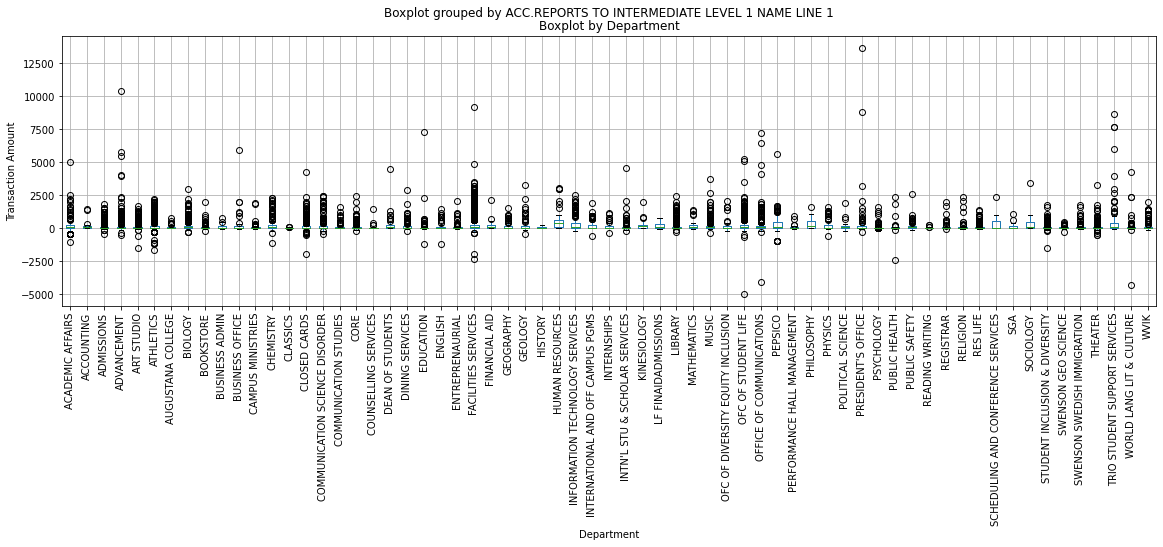

In [23]:
from matplotlib.pyplot import figure

boxplot = df.boxplot(column = ['FIN.TRANSACTION AMOUNT'], by=["ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1"], figsize=(19,5))
plt.xlabel("Department")
plt.ylabel("Transaction Amount")
plt.title("Boxplot by Department")
plt.xticks(rotation=90)
plt.show()

Lost/Stolen in ACC.ACCOUNT DESCRIPTION

In [24]:
df[df['ACC.ACCOUNT STATUS DESCRIPTION'] == 'LOST/STOLEN']

Account (cleansed) Name (Cleansed) FIN.POSTING DATE  \
22                   1025         Name253       01/04/2021   
24                   1233         Name438       01/04/2021   
26                   1278         Name346       01/04/2021   
31                   1279         Name379       01/05/2021   
43                   1157         Name469       01/05/2021   
...                   ...             ...              ...   
18045                1052         Name281       12/20/2021   
18112                1217         Name332       12/22/2021   
18178                1062         Name506       12/23/2021   
18282                1060         Name438       12/30/2021   
18283                1052         Name281       12/30/2021   

            MCH.MERCHANT NAME  \
22            COMCAST CHICAGO   
24                   NAGT.ORG   
26     28 - LOU MALNATIS PIZZ   
31     AMAZON PRIME*2E3JK9H93   
43     HANDY TRUE VALUE HARDW   
...                       ...   
18045     SUMMIT GRAPHICS INC   
18112  CANVA* I03276-23252089   
18178            PEAVEY CORP.   
18282  RIGAKU AMERICAS HOLDIN   
18283     DTV*DIRECTV SERVICE   

                                     MCH.MCC DESCRIPTION  \
22     CABLE, SATELLITE, OTHER PAY TELEVISION, RADIO ...   
24     ORGANIZATIONS, MEMBERSHIP-NOT ELSEWHERE CLASSI...   
26                            EATING PLACES, RESTAURANTS   
31     DIRECT MARKETING-CONTINUITY/SUBSCRIPTION MERCH...   
43                                       HARDWARE STORES   
...                                                  ...   
18045              MISCELLANEOUS PUBLISHING AND PRINTING   
18112                               PHOTOGRAPHIC STUDIOS   
18178         BUSINESS SERVICES-NOT ELSEWHERE CLASSIFIED   
18282         BUSINESS SERVICES-NOT ELSEWHERE CLASSIFIED   
18283  CABLE, SATELLITE, OTHER PAY TELEVISION, RADIO ...   

       FIN.TRANSACTION AMOUNT  MCH.CITY NAME MCH.COUNTRY CODE  \
22                      88.40   800-266-2278              USA   
24                      75.00     NORTHFIELD              USA   
26                      45.79        CHICAGO              USA   
31                      12.99  AMZN.COM/BILL              USA   
43                      54.25    ROCK ISLAND              USA   
...                       ...            ...              ...   
18045                 1186.05         MOLINE              USA   
18112                   12.99         CAMDEN              USA   
18178                   51.52         LENEXA              USA   
18282                   43.70     2813622300              USA   
18283                  279.98   800-347-3288              USA   

      MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
22                      IL                    60173   
24                      MN                    55057   
26                      IL                    60622   
31                      WA                    98109   
43                      IL                    61201   
...                    ...                      ...   
18045                   IL                612659756   
18112                   DE                    19934   
18178                   KS                    66215   
18282                   TX                    77381   
18283                   CA                    90245   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
22                                         ADMISSIONS   
24                                       CLOSED CARDS   
26                                       CLOSED CARDS   
31                                OFC OF STUDENT LIFE   
43                                FACILITIES SERVICES   
...                                               ...   
18045                                         PEPSICO   
18112                                         THEATER   
18178                                       CHEMISTRY   
18282                                         GEOLOGY   
18283                                         PEPSICO   

      ACC.REPORTS

In [25]:
df.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT
count        18299.000000            18299.000000
mean          1177.250888              179.564387
std            106.832047              426.835014
min           1002.000000            -4938.300000
25%           1079.000000               20.000000
50%           1159.000000               55.670000
75%           1278.000000              174.125000
max           1358.000000            13665.100000

Filter out negative data. Negative values are refunds/payments towards credit

In [26]:
# filter out values less than 1. This eliminates negative values and small values
df = df[df['FIN.TRANSACTION AMOUNT'] > 1]

In [27]:
df.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT
count        17688.000000            17688.000000
mean          1176.404285              191.084916
std            106.833348              422.900093
min           1002.000000                1.040000
25%           1078.000000               22.680000
50%           1157.000000               60.000000
75%           1277.000000              182.415000
max           1358.000000            13665.100000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


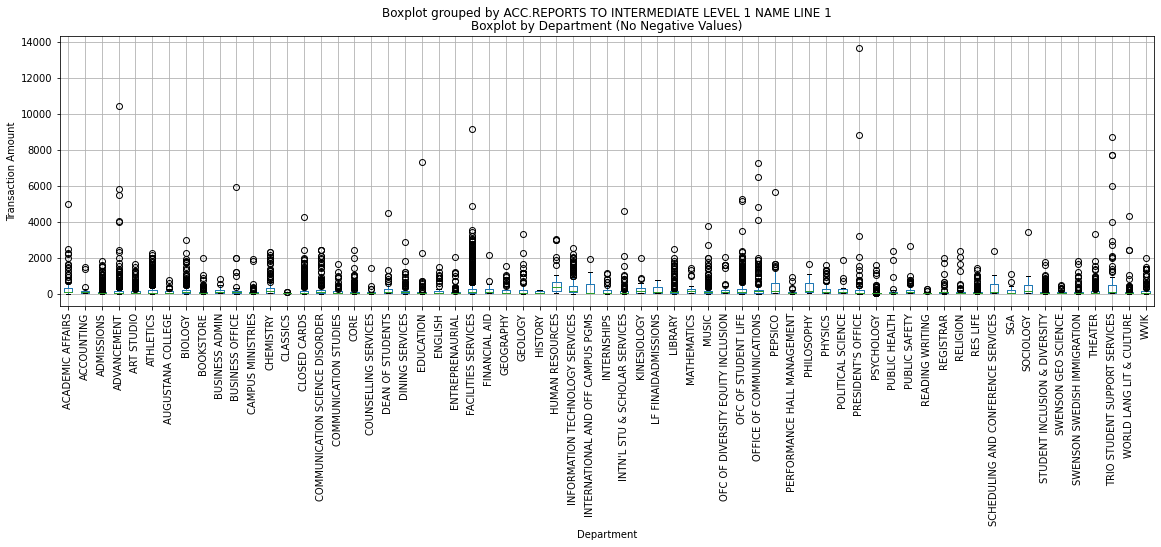

In [28]:
boxplot = df.boxplot(column = ['FIN.TRANSACTION AMOUNT'], by=["ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1"], figsize=(19,5))
plt.xlabel("Department")
plt.ylabel("Transaction Amount")
plt.title("Boxplot by Department (No Negative Values)")
plt.xticks(rotation=90)
plt.show()

# EDA

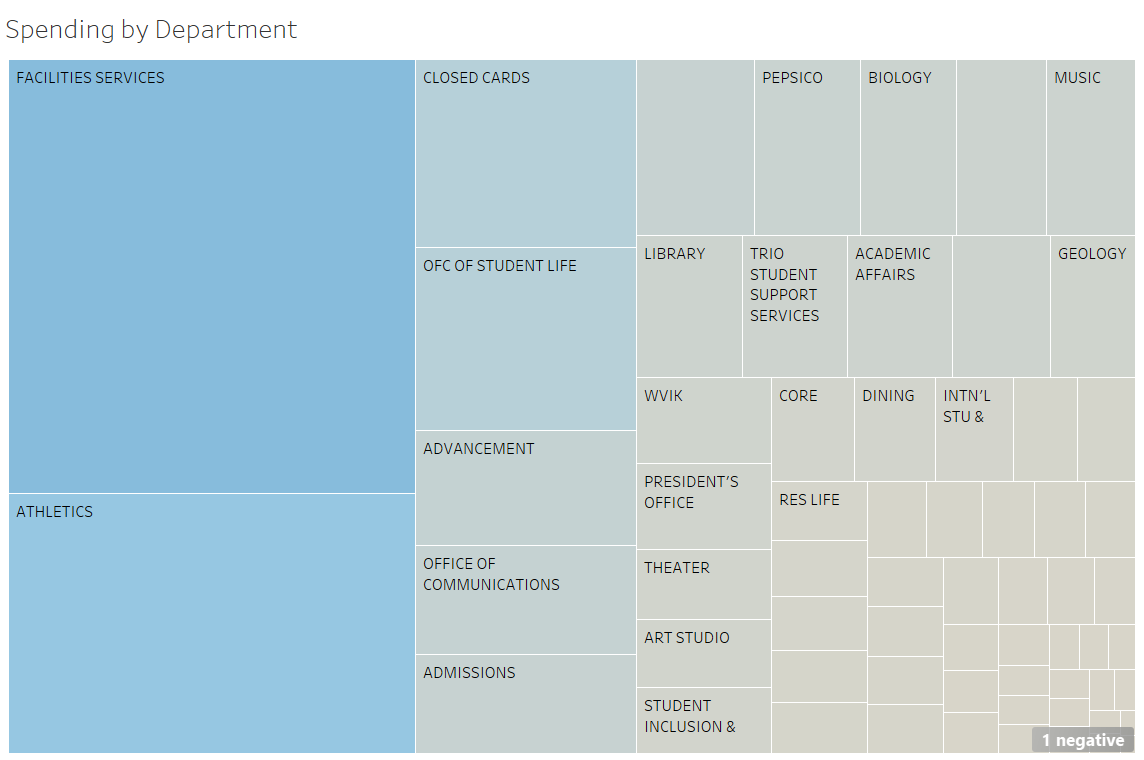

Distribution of financial transactions

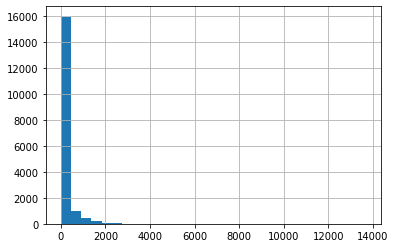

In [29]:
# look at all data
hist = df["FIN.TRANSACTION AMOUNT"].hist(bins=30)

8966 values


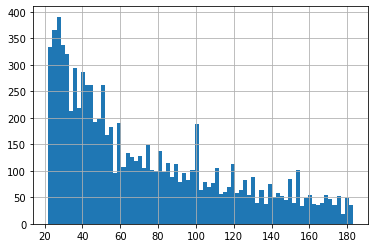

In [30]:
#look at middle 50% of the data
twentyFifth = 22
seventyFifth = 183

mid50 = df[(df['FIN.TRANSACTION AMOUNT'] > twentyFifth) & (df['FIN.TRANSACTION AMOUNT'] < seventyFifth)]
print(len(mid50), "values")
hist = mid50["FIN.TRANSACTION AMOUNT"].hist(bins=75)

4413 values


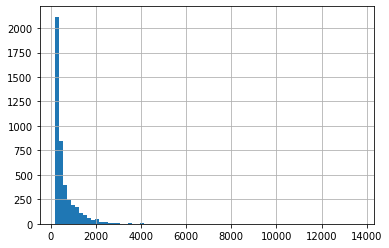

In [31]:
# look at above 75
above75 = df[(df['FIN.TRANSACTION AMOUNT'] > seventyFifth)]
print(len(above75), "values")
hist = above75["FIN.TRANSACTION AMOUNT"].hist(bins=75)

In [32]:
above75.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT
count         4413.000000             4413.000000
mean          1173.658509              605.261632
std            105.682546              694.304749
min           1002.000000              183.150000
25%           1092.000000              248.550000
50%           1135.000000              379.000000
75%           1277.000000              688.860000
max           1358.000000            13665.100000

4297 values


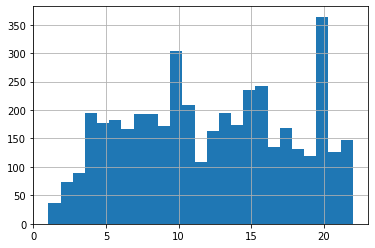

In [33]:
# look at below 25
below25 = df[(df['FIN.TRANSACTION AMOUNT'] < twentyFifth)]
print(len(below25), "values")
hist = below25["FIN.TRANSACTION AMOUNT"].hist(bins=25)

In [34]:
below25.describe()

Account (cleansed)  FIN.TRANSACTION AMOUNT
count         4297.000000             4297.000000
mean          1174.311613               12.212139
std            108.979578                5.567387
min           1002.000000                1.040000
25%           1072.000000                7.580000
50%           1165.000000               12.110000
75%           1277.000000               16.850000
max           1358.000000               21.990000

Distribution of total transactions over the year

In [35]:
# new df for plotting time
dfTime = df.copy()

dfTime["Month"] = dfTime["FIN.POSTING DATE"]
dfTime["Month"] = dfTime["Month"].str[:2]

dfTime.head()

Account (cleansed) Name (Cleansed) FIN.POSTING DATE  \
1                1135         Name516       01/04/2021   
2                1099         Name254       01/04/2021   
3                1102         Name250       01/04/2021   
4                1133         Name324       01/04/2021   
5                1155         Name428       01/04/2021   

        MCH.MERCHANT NAME                                MCH.MCC DESCRIPTION  \
1    JOHNSON DISTRIBUTING        NONDURABLE GOODS (NOT ELSEWHERE CLASSIFIED)   
2          WAL-MART #4511                       GROCERY STORES, SUPERMARKETS   
3  GOOGLE*GSUITE QUADCITY  COMP PROGRAMING,DATA PRCSNG,INTGRTD SYS DSGN SRVS   
4    WM SUPERCENTER #2231                       GROCERY STORES, SUPERMARKETS   
5  AMZN MKTP US*B42NL2KL3                                        BOOK STORES   

   FIN.TRANSACTION AMOUNT  MCH.CITY NAME MCH.COUNTRY CODE  \
1                   28.50    563-4453600              USA   
2                   20.12         SILVIS              USA   
3                    6.00       INTERNET              USA   
4                    7.48         MOLINE              USA   
5                   34.49  AMZN.COM/BILL              USA   

  MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
1                   IA                    52806   
2                   IL                    61282   
3                   CA                    94043   
4                   IL                    61265   
5                   WA                    98109   

  ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
1                             FACILITIES SERVICES   
2                                     ADVANCEMENT   
3                                            WVIK   
4                             FACILITIES SERVICES   
5                                         LIBRARY   

  ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1  \
1                               AUGUSTANA COLLEGE   
2                               AUGUSTANA COLLEGE   
3                               AUGUSTANA COLLEGE   
4                               AUGUSTANA COLLEGE   
5                               AUGUSTANA COLLEGE   

  ACC.ACCOUNT STATUS DESCRIPTION FIN.TRANSACTION DATE Employee ID (cleansed)  \
1                         ACTIVE           12/31/2020                 Emp806   
2                         ACTIVE           12/31/2020                 Emp708   
3                 ACCOUNT CLOSED           01/02/2021                 Emp714   
4                         ACTIVE           01/02/2021                 Emp801   
5                         ACTIVE           12/31/2020                 Emp820   

  Month  
1    01  
2    01  
3    01  
4    01  
5    01

No handles with labels found to put in legend.


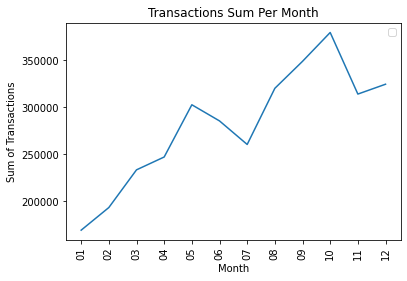

<Figure size 1280x800 with 0 Axes>

In [36]:
# group data
dateTemp = dfTime.groupby('Month').sum()
transactions = dateTemp['FIN.TRANSACTION AMOUNT'].to_list()

dateList = dfTime['Month'].drop_duplicates().to_list()

# assign to arrays
dates = np.array(dateList)
dates.sort()
returns = np.array(transactions)

# Plot the entire data first
plt.plot(dates, returns)
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
plt.xlabel('Month')
plt.ylabel('Sum of Transactions')
plt.title('Transactions Sum Per Month')

plt.legend()
plt.figure(figsize=(16,10), dpi= 80)
plt.show()

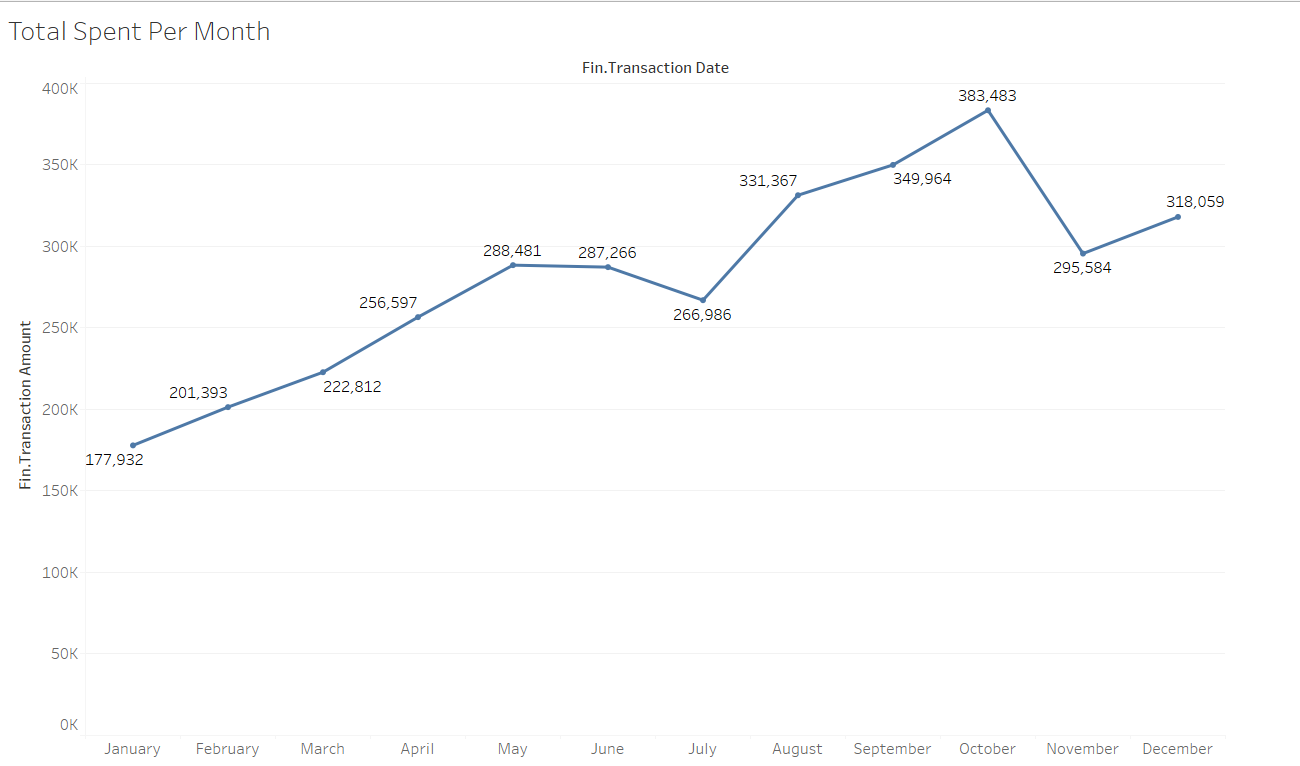

Spending by Department over year

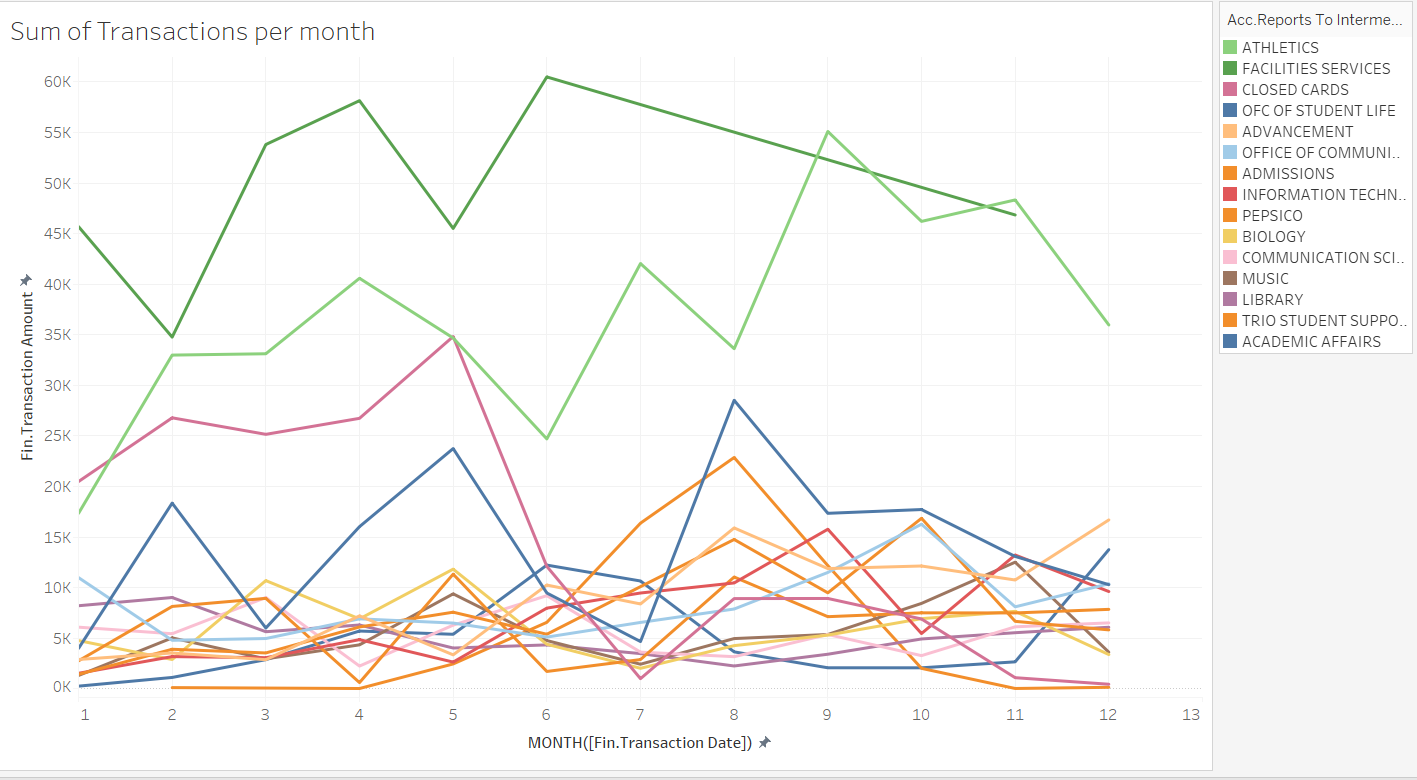

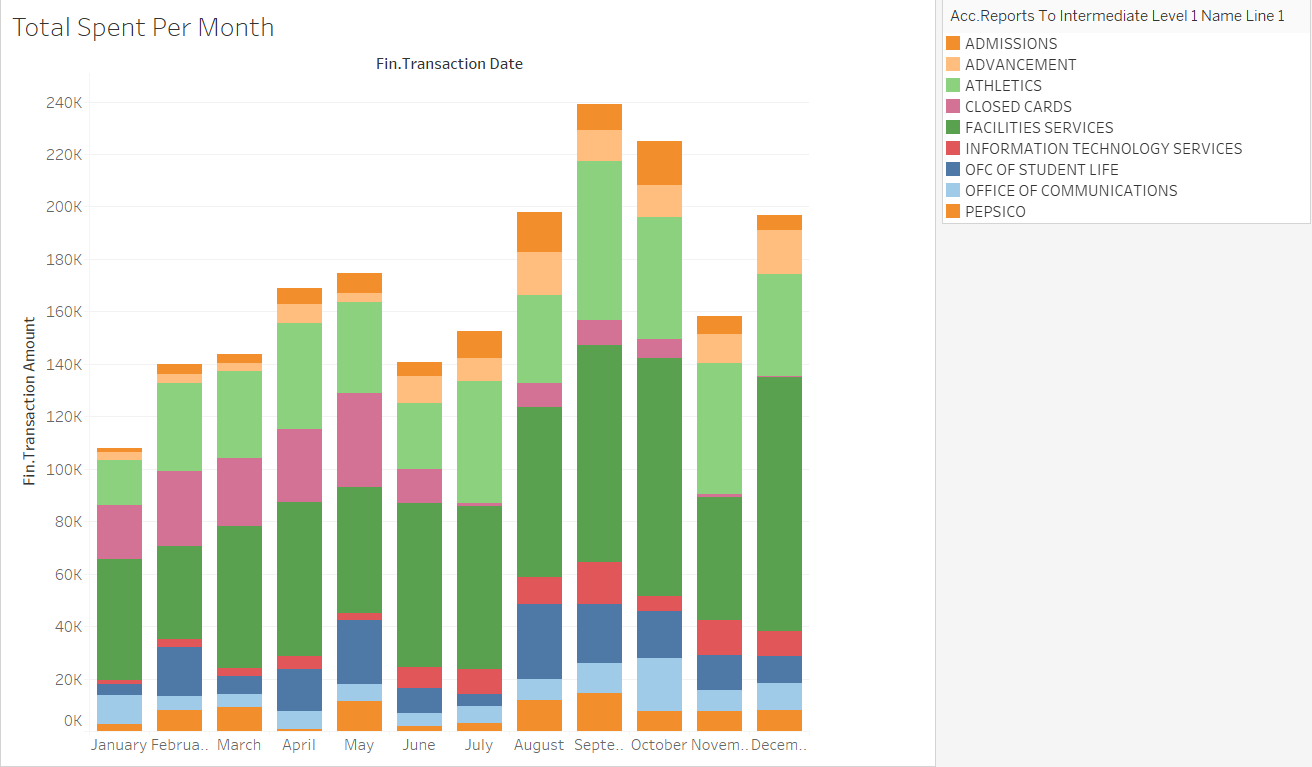

Department who spend the most

In [37]:
# shows stats about department
grouped = pd.DataFrame()
grouped["Sum"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').sum()["FIN.TRANSACTION AMOUNT"]
grouped["Count"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').count()["FIN.TRANSACTION AMOUNT"]
grouped["Mean"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').mean()["FIN.TRANSACTION AMOUNT"]
grouped["Min"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').min()["FIN.TRANSACTION AMOUNT"]
grouped["Max"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').max()["FIN.TRANSACTION AMOUNT"]
grouped["Median"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').median()["FIN.TRANSACTION AMOUNT"]
grouped["StDev"] = df.groupby('ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1').std()["FIN.TRANSACTION AMOUNT"]

grouped

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  import sys


Sum  Count        Mean  \
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1                                 
ACADEMIC AFFAIRS                                  74019.59    275  269.162145   
ACCOUNTING                                         5470.32     32  170.947500   
ADMISSIONS                                        92621.44    920  100.675478   
ADVANCEMENT                                      107147.51    548  195.524653   
ART STUDIO                                        41323.23    282  146.536277   
...                                                    ...    ...         ...   
SWENSON SWEDISH IMMIGRATION                       15323.16    107  143.207103   
THEATER                                           43031.36    314  137.042548   
TRIO STUDENT SUPPORT SERVICES                     62911.12     89  706.866517   
WORLD LANG LIT & CULTURE                          23230.06    216  107.546574   
WVIK                                              49071.06    309  158.806019   

                                                  Min       Max   Median  \
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1                            
ACADEMIC AFFAIRS                                 2.01   4999.00  100.000   
ACCOUNTING                                       4.28   1465.90   78.275   
ADMISSIONS                                       1.07   1811.25   32.285   
ADVANCEMENT                                      1.61  10429.44   44.005   
ART STUDIO                                       4.26   1668.70   54.875   
...                                               ...       ...      ...   
SWENSON SWEDISH IMMIGRATION                      2.38   1801.20   37.450   
THEATER                                          2.99   3316.00   39.235   
TRIO STUDENT SUPPORT SERVICES                    8.58   8694.00  110.000   
WORLD LANG LIT & CULTURE                         2.51   4300.00   31.740   
WVIK                                             1.29   2000.00   39.980   

                                                       StDev  
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1               
ACADEMIC AFFAIRS                                  460.846353  
ACCOUNTING                                        339.827680  
ADMISSIONS                                        205.498300  
ADVANCEMENT                                       658.465611  
ART STUDIO                                        265.867486  
...                                                      ...  
SWENSON SWEDISH IMMIGRATION                       304.435911  
THEATER                                           291.904646  
TRIO STUDENT SUPPORT SERVICES                    1658.156208  
WORLD LANG LIT & CULTURE                          380.547885  
WVIK                                              323.040431  

[65 rows x 7 columns]

In [38]:
# alternative to above
# grouped1 = df.groupby(['ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1']).agg({'FIN.TRANSACTION AMOUNT':['sum','count', 'median', 'min', 'max', 'mean']}).reset_index()

Most Common Merchants

In [39]:
# shows stats about merchants
groupMerch = pd.DataFrame()
groupMerch["Sum"] = df.groupby('MCH.MERCHANT NAME').sum()["FIN.TRANSACTION AMOUNT"]
groupMerch["Count"] = df.groupby('MCH.MERCHANT NAME').count()["FIN.TRANSACTION AMOUNT"]
groupMerch["Mean"] = df.groupby('MCH.MERCHANT NAME').mean()["FIN.TRANSACTION AMOUNT"]
groupMerch["Min"] = df.groupby('MCH.MERCHANT NAME').min()["FIN.TRANSACTION AMOUNT"]
groupMerch["Max"] = df.groupby('MCH.MERCHANT NAME').max()["FIN.TRANSACTION AMOUNT"]
groupMerch["Median"] = df.groupby('MCH.MERCHANT NAME').median()["FIN.TRANSACTION AMOUNT"]
groupMerch["StDev"] = df.groupby('MCH.MERCHANT NAME').std()["FIN.TRANSACTION AMOUNT"]

groupMerch

Output hidden; open in https://colab.research.google.com to view.

In [40]:
groupMerch

Output hidden; open in https://colab.research.google.com to view.

Top Merchant by Department

In [41]:
# shows top 5 merchants for each department
numTopRows = 5

groupMerchDept = pd.DataFrame()
groupMerchDept["Sum"] = df.groupby(['ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1', 'MCH.MERCHANT NAME']).sum()["FIN.TRANSACTION AMOUNT"]
groupMerchDept = groupMerchDept.sort_values('Sum', ascending=False)
groupMerchDept.groupby("ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1").head(numTopRows)

Sum
ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1 MCH.MERCHANT NAME               
FACILITIES SERVICES                             REPUBLIC SERVICES TRAS  54711.09
                                                SQ *NORTHWEST MECHANIC  54642.06
                                                ENTERPRISE RENT-A-CAR   39964.73
ATHLETICS                                       SOUTHWEST AIRLINES      32927.28
GEOLOGY                                         DELTA                   27059.52
...                                                                          ...
COUNSELLING SERVICES                            ALDI 68025                 80.71
SCHEDULING AND CONFERENCE SERVICES              AMZN MKTP US*272QF96E2     77.96
CLASSICS                                        LEMONGRASS CAFE            74.70
                                                PAYPAL *CLASSICALAS        63.00
FINANCIAL AID                                   STAPLES       00104448     22.46

[325 rows x 1 columns]

Employees Who Spend the Most

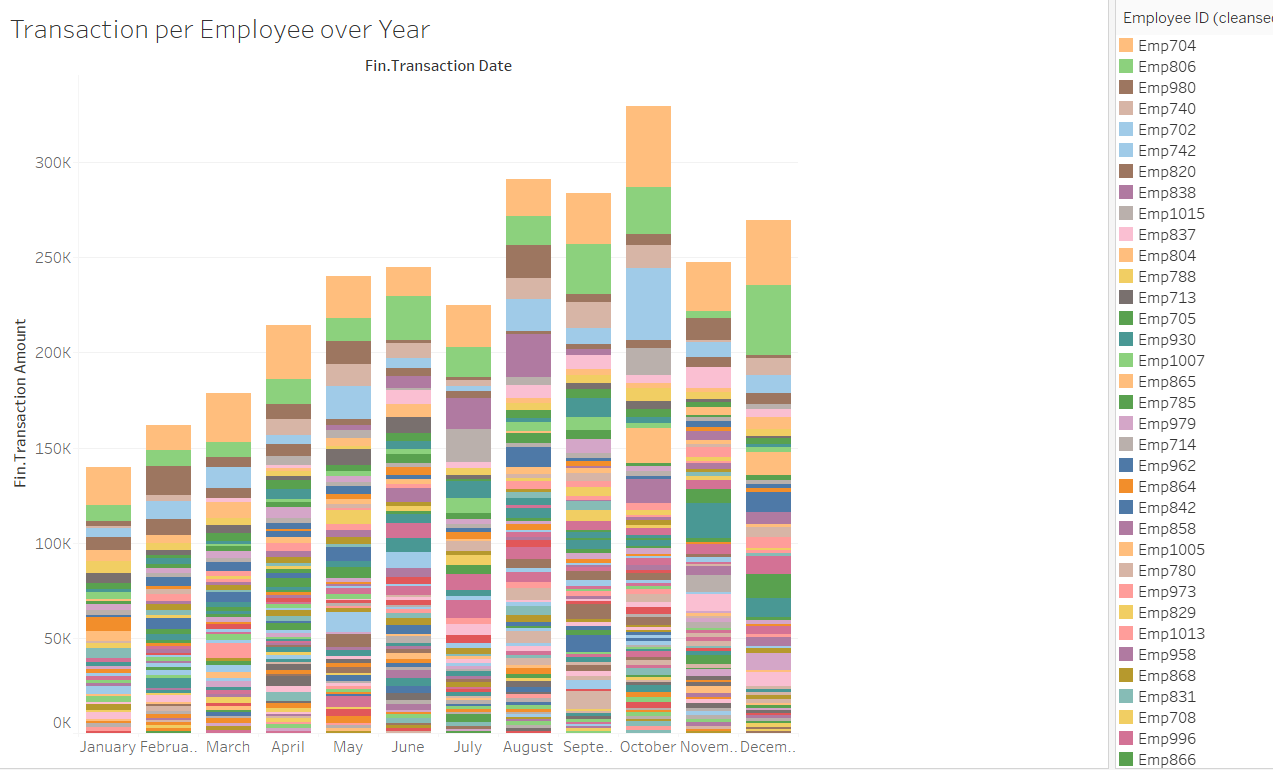

In [43]:
from scipy.stats import zscore

# shows stats about an employees spending
groupEmp = pd.DataFrame()
groupEmp["Sum"] = df.groupby('Employee ID (cleansed)').sum()["FIN.TRANSACTION AMOUNT"]
groupEmp["Count"] = df.groupby('Employee ID (cleansed)').count()["FIN.TRANSACTION AMOUNT"]
groupEmp["Mean"] = df.groupby('Employee ID (cleansed)').mean()["FIN.TRANSACTION AMOUNT"]
groupEmp["Min"] = df.groupby('Employee ID (cleansed)').min()["FIN.TRANSACTION AMOUNT"]
groupEmp["Max"] = df.groupby('Employee ID (cleansed)').max()["FIN.TRANSACTION AMOUNT"]
groupEmp["Median"] = df.groupby('Employee ID (cleansed)').median()["FIN.TRANSACTION AMOUNT"]
groupEmp["StDev"] = df.groupby('Employee ID (cleansed)').std()["FIN.TRANSACTION AMOUNT"]
groupEmp["Q1"] = df.groupby("Employee ID (cleansed)").quantile(.25)["FIN.TRANSACTION AMOUNT"]
groupEmp["Q3"] = df.groupby("Employee ID (cleansed)").quantile(.75)["FIN.TRANSACTION AMOUNT"]

groupEmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Dropping invalid columns in DataFr

Sum  Count        Mean    Min      Max   Median  \
Employee ID (cleansed)                                                         
Emp1000                  2024.73     17  119.101765   5.00   700.53   30.000   
Emp1001                  7893.75     27  292.361111   4.45  1418.00  180.000   
Emp1002                  5830.53     13  448.502308  24.40  1406.00  200.400   
Emp1003                 12136.00     58  209.241379   5.04  2000.00  134.765   
Emp1004                  3069.61     12  255.800833  13.12  1000.00   51.780   
...                          ...    ...         ...    ...      ...      ...   
Emp995                    243.37      3   81.123333  26.74   141.36   75.270   
Emp996                  23048.07    105  219.505429   8.97  1302.91  129.860   
Emp997                   7785.07     47  165.639787   2.74   900.00   10.000   
Emp998                   6532.59     23  284.025652   8.23  2629.55  102.240   
Emp999                    789.04     10   78.904000  10.84   259.97   39.150   

                             StDev       Q1        Q3  
Employee ID (cleansed)                                 
Emp1000                 176.779035  20.3700  198.4800  
Emp1001                 405.954301  17.6450  263.5000  
Emp1002                 506.344239  88.0600  877.7600  
Emp1003                 336.727301  53.3950  221.1875  
Emp1004                 360.488807  30.3650  324.6275  
...                            ...      ...       ...  
Emp995                   57.533749  51.0050  108.3150  
Emp996                  230.247847  51.1500  313.6200  
Emp997                  251.385628  10.0000  283.7700  
Emp998                  549.988444  32.5000  287.5000  
Emp999                   97.192927  19.7775   64.9700  

[333 rows x 9 columns]

Top Merchants by Employee

In [44]:
# top merchants by employee
numTopRows = 5

groupMerchEmp = pd.DataFrame()
groupMerchEmp["Sum"] = df.groupby(['Employee ID (cleansed)', 'MCH.MERCHANT NAME']).sum()["FIN.TRANSACTION AMOUNT"]
groupMerchEmp = groupMerchEmp.sort_values('Sum', ascending=False)
groupMerchEmp.groupby("Employee ID (cleansed)").head(numTopRows)

Sum
Employee ID (cleansed) MCH.MERCHANT NAME               
Emp704                 SQ *NORTHWEST MECHANIC  54642.06
Emp806                 REPUBLIC SERVICES TRAS  50816.99
Emp742                 DELTA                   29939.52
Emp806                 ENTERPRISE RENT-A-CAR   28995.86
Emp704                 TRACHTENBARG CO         23346.17
...                                                 ...
Emp1025                AUGUSTANA DINING SERVI      7.55
Emp1019                AUGUSTANA BOOKSTORE         7.37
Emp825                 GO.SKYPE.COM/BILL           7.13
Emp744                 SQ *CAFE MOXO               6.62
Emp1016                DOLLAR-GENERAL #3057        5.41

[1494 rows x 1 columns]

Employee Spending Habits Over Year

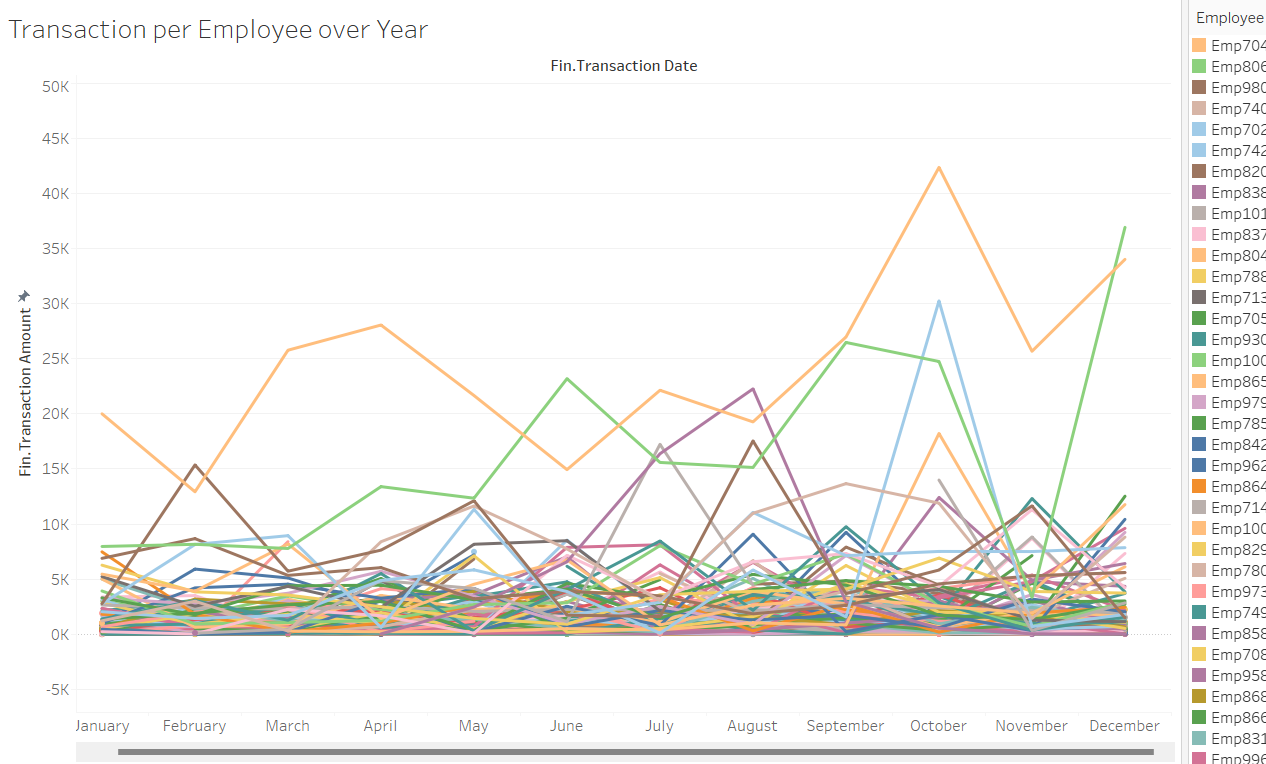

# Defining Normal Vs. Abnormal

Goal of this project: Identify normal spending behavior of an employee. Employee ID (cleansed) was chosen because there are too may unique merchants to identify wchih merchants are normal and which are not. This project focuses on narrowing down to the scope of an employee and identifying normal spending behavior

The following outlier/normailty detection methods to define rules will be: 
1. Transactions identified by unsupervised Isolation Forest as abnormal
2. Z-Score Graphing of Employee ID transactions vs count
3. Z-Score Graphing of Merchant transactions vs count
4. Z-Score Graphing of Account transactions vs count


Future work: More data over time will help highligh abnormalities. May also be smart to build profiles of merchants, accounts, and employees to more readily identify abnormalities in spending.

Doing so will allow for better identification or normal vs. abnormal behavior in employee spending. More data over years will surely highlight abnormalities!

In [ ]:
# create data frame to compare abnormal detection methods
df_anomolies = df.copy()
print(len(df_anomolies))
df_anomolies.head()

17688


Account (cleansed) Name (Cleansed) FIN.POSTING DATE  \
1                1135         Name516       01/04/2021   
2                1099         Name254       01/04/2021   
3                1102         Name250       01/04/2021   
4                1133         Name324       01/04/2021   
5                1155         Name428       01/04/2021   

        MCH.MERCHANT NAME                                MCH.MCC DESCRIPTION  \
1    JOHNSON DISTRIBUTING        NONDURABLE GOODS (NOT ELSEWHERE CLASSIFIED)   
2          WAL-MART #4511                       GROCERY STORES, SUPERMARKETS   
3  GOOGLE*GSUITE QUADCITY  COMP PROGRAMING,DATA PRCSNG,INTGRTD SYS DSGN SRVS   
4    WM SUPERCENTER #2231                       GROCERY STORES, SUPERMARKETS   
5  AMZN MKTP US*B42NL2KL3                                        BOOK STORES   

   FIN.TRANSACTION AMOUNT  MCH.CITY NAME MCH.COUNTRY CODE  \
1                   28.50    563-4453600              USA   
2                   20.12         SILVIS              USA   
3                    6.00       INTERNET              USA   
4                    7.48         MOLINE              USA   
5                   34.49  AMZN.COM/BILL              USA   

  MCH.STATE / PROVINCE MCH.MERCHANT POSTAL CODE  \
1                   IA                    52806   
2                   IL                    61282   
3                   CA                    94043   
4                   IL                    61265   
5                   WA                    98109   

  ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1  \
1                             FACILITIES SERVICES   
2                                     ADVANCEMENT   
3                                            WVIK   
4                             FACILITIES SERVICES   
5                                         LIBRARY   

  ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1  \
1                               AUGUSTANA COLLEGE   
2                               AUGUSTANA COLLEGE   
3                               AUGUSTANA COLLEGE   
4                               AUGUSTANA COLLEGE   
5                               AUGUSTANA COLLEGE   

  ACC.ACCOUNT STATUS DESCRIPTION FIN.TRANSACTION DATE Employee ID (cleansed)  
1                         ACTIVE           12/31/2020                 Emp806  
2                         ACTIVE           12/31/2020                 Emp708  
3                 ACCOUNT CLOSED           01/02/2021                 Emp714  
4                         ACTIVE           01/02/2021                 Emp801  
5                         ACTIVE           12/31/2020                 Emp820

In [ ]:
# drop useless columns
col_drop = ['Name (Cleansed)', 'FIN.POSTING DATE', 'MCH.MCC DESCRIPTION',
       'MCH.CITY NAME', 'MCH.COUNTRY CODE', 'MCH.STATE / PROVINCE',
       'MCH.MERCHANT POSTAL CODE',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 2 NAME LINE 1',
       'ACC.ACCOUNT STATUS DESCRIPTION']

df_anomolies = drop_other_cols(df_anomolies, col_drop)

In [ ]:
df_anomolies.columns

Index(['Account (cleansed)', 'MCH.MERCHANT NAME', 'FIN.TRANSACTION AMOUNT',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1',
       'FIN.TRANSACTION DATE', 'Employee ID (cleansed)'],
      dtype='object')

Z-Score Graph of Employee ID

In [ ]:
# combine df_anomolies with groupEmp to get stats about employess transactions
groupEmpAnom = pd.DataFrame()
groupEmpAnom["EmpMean"] = df.groupby('Employee ID (cleansed)').mean()["FIN.TRANSACTION AMOUNT"]
groupEmpAnom["EmpStDev"] = df.groupby('Employee ID (cleansed)').std()["FIN.TRANSACTION AMOUNT"]
groupEmpAnom["EmpTotalCountofTransactions"] = df.groupby('Employee ID (cleansed)').count()["FIN.TRANSACTION AMOUNT"]
#merge to get Employee ID population mean and std dev
df_anomolies = df_anomolies.merge(groupEmpAnom,on='Employee ID (cleansed)',how="left")


# combine df_anomolies with info about count of transactions per employee per merchant
groupMerchAnom = pd.DataFrame()
groupMerchAnom["CountPerEmpOfTransPerMerch"] = df.groupby(['Employee ID (cleansed)', 'MCH.MERCHANT NAME']).count()["FIN.TRANSACTION AMOUNT"]
#merge to get info about count per employee
df_anomolies = df_anomolies.merge(groupMerchAnom,on=['Employee ID (cleansed)', 'MCH.MERCHANT NAME'],how="left")


# get info about num transactions population of merchant
groupMerchPop = pd.DataFrame()
groupMerchPop["TotalTransPerMerch"] = df.groupby('MCH.MERCHANT NAME').count()["FIN.TRANSACTION AMOUNT"]
#merge to get info about merchant population count
df_anomolies = df_anomolies.merge(groupMerchPop,on=['MCH.MERCHANT NAME'],how="left")

# get stdev of count of transactions per employee per merchant
test = pd.DataFrame()
test["CountPerEmpStDev"] = df_anomolies.groupby("MCH.MERCHANT NAME").std()["CountPerEmpOfTransPerMerch"]
test["MeanPerEmpStDev"] = df_anomolies.groupby("MCH.MERCHANT NAME").mean()["CountPerEmpOfTransPerMerch"]

df_anomolies = df_anomolies.merge(test,on=['MCH.MERCHANT NAME'],how="left")

# compute z-score per row as: z-score = (FIN.TRANSACTION AMOUNT - EmployeeID mean) / EmployeeID stdev
df_anomolies["EmpIDZScoreTrAmt"] = (df_anomolies["FIN.TRANSACTION AMOUNT"] - df_anomolies["EmpMean"]) / df_anomolies["EmpStDev"]
df_anomolies["EmpIDZScoreNumTr"] = (df_anomolies["CountPerEmpOfTransPerMerch"] - df_anomolies["MeanPerEmpStDev"]) / df_anomolies["CountPerEmpStDev"]


# view 
df_anomolies

Output hidden; open in https://colab.research.google.com to view.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


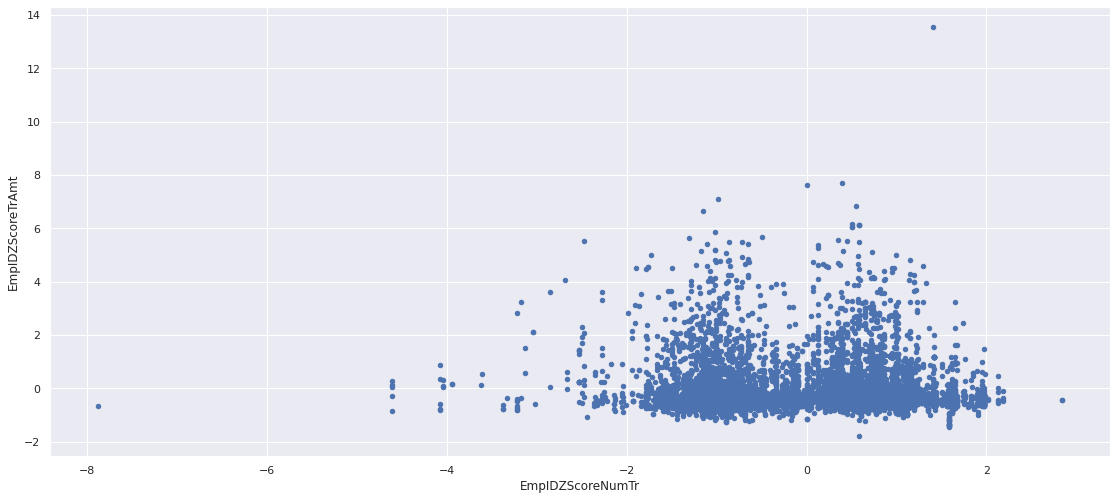

In [ ]:
# create plot of transaction amount over number of transactions for an employee
ax1 = df_anomolies.plot.scatter(y='EmpIDZScoreTrAmt', x='EmpIDZScoreNumTr')

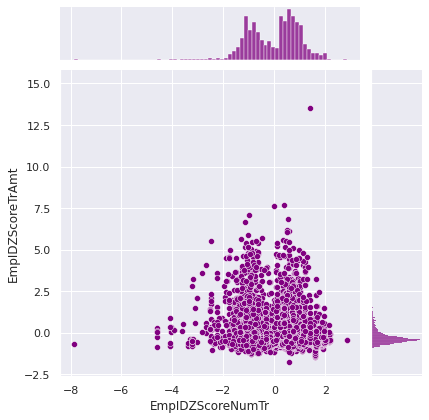

In [ ]:
sns.jointplot(data=df_anomolies, x="EmpIDZScoreNumTr", y="EmpIDZScoreTrAmt", color='purple')

In [ ]:
# decide normality
topCutOff = 3
bottomCutOff = -3

df_anomolies.loc[df_anomolies["EmpIDZScoreTrAmt"] > topCutOff, "EmpIDZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["EmpIDZScoreTrAmt"] < bottomCutOff, "EmpIDZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["EmpIDZScoreNumTr"] > topCutOff, "EmpIDZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["EmpIDZScoreNumTr"] < bottomCutOff, "EmpIDZAssign"] = 'Abnormal'

df_anomolies.loc[df_anomolies["EmpIDZAssign"].isnull(), "EmpIDZAssign"] = 'Normal'

print("Number of records marked as abnormal: ", df_anomolies[df_anomolies["EmpIDZAssign"] == 'Abnormal'].count()[1])
print("Number of records marked as normal: ", df_anomolies[df_anomolies["EmpIDZAssign"] == 'Normal'].count()[1])

Number of records marked as abnormal:  473
Number of records marked as normal:  17178


In [ ]:
# remove testing columns
col_drop = ['EmpMean', 'EmpStDev', 'EmpTotalCountofTransactions',
       'CountPerEmpOfTransPerMerch', 'TotalTransPerMerch', 'CountPerEmpStDev',
       'MeanPerEmpStDev']
# , 'EmpIDZScoreTrAmt', 'EmpIDZScoreNumTr'

df_anomolies = drop_other_cols(df_anomolies, col_drop)

# for testing
df_anomoliesCopy = df_anomolies.copy()

In [ ]:
# run when before debugging next section
df_anomolies = df_anomolies.copy()

Z-Score Graph of Merchant

In [ ]:
# combine df_anomolies with merchant stats
groupEmpAnom = pd.DataFrame()
groupEmpAnom["MerchMean"] = df.groupby('MCH.MERCHANT NAME').mean()["FIN.TRANSACTION AMOUNT"]
groupEmpAnom["MerchStDev"] = df.groupby('MCH.MERCHANT NAME').std()["FIN.TRANSACTION AMOUNT"]
#merge to merchant mean and st dev
df_anomolies = df_anomolies.merge(groupEmpAnom,on='MCH.MERCHANT NAME',how="left")

# get count
groupMerchPop = pd.DataFrame()
groupMerchPop["TotalTransPerMerch"] = df.groupby('MCH.MERCHANT NAME').count()["FIN.TRANSACTION AMOUNT"]
df_anomolies = df_anomolies.merge(groupMerchPop,on=['MCH.MERCHANT NAME'],how="left")


# get stdev and mean of count (num transactoins)
meanCountMerch = df_anomolies["TotalTransPerMerch"].mean()
stdCountMerch = df_anomolies["TotalTransPerMerch"].std()

# compute z-score per row as: z-score = (FIN.TRANSACTION AMOUNT - MerchMean) / MerchStDev
df_anomolies["MerchZScoreTrAmt"] = (df_anomolies["FIN.TRANSACTION AMOUNT"] - df_anomolies["MerchMean"]) / df_anomolies["MerchStDev"]
df_anomolies["MerchZScoreNumTr"] = (df_anomolies["TotalTransPerMerch"] - meanCountMerch) / stdCountMerch

# view 
df_anomolies

Output hidden; open in https://colab.research.google.com to view.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


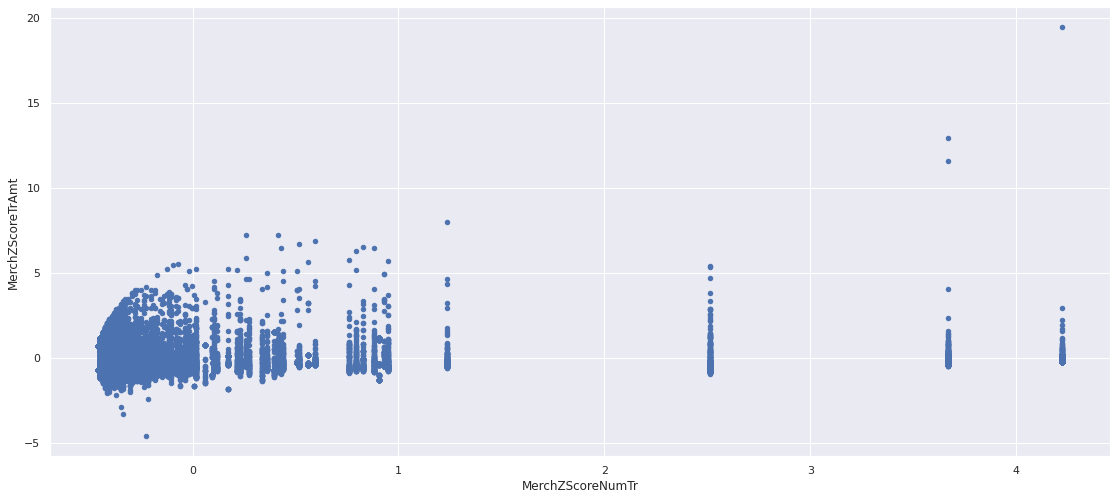

In [ ]:
# create plot of transaction amount over number of transactions for merchant
ax1 = df_anomolies.plot.scatter(y='MerchZScoreTrAmt', x='MerchZScoreNumTr')

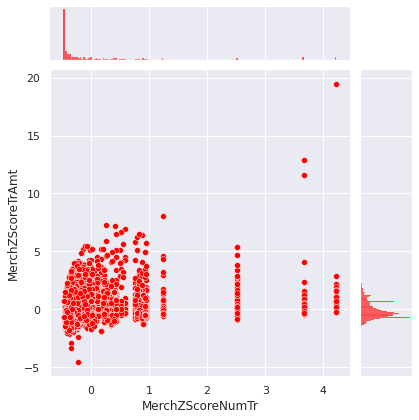

In [ ]:
sns.jointplot(data=df_anomolies, x="MerchZScoreNumTr", y="MerchZScoreTrAmt", color='red')

In [ ]:
# decide normality
topCutOff = 3
bottomCutOff = -3

df_anomolies.loc[df_anomolies["MerchZScoreTrAmt"] > topCutOff, "MchZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["MerchZScoreTrAmt"] < bottomCutOff, "MchZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["MerchZScoreNumTr"] > topCutOff, "MchZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["MerchZScoreNumTr"] < bottomCutOff, "MchZAssign"] = 'Abnormal'

df_anomolies.loc[df_anomolies["MchZAssign"].isnull(), "MchZAssign"] = 'Normal'

print("Number of records marked as abnormal: ", df_anomolies[df_anomolies["MchZAssign"] == 'Abnormal'].count()[1])
print("Number of records marked as normal: ", df_anomolies[df_anomolies["MchZAssign"] == 'Normal'].count()[1])

Number of records marked as abnormal:  968
Number of records marked as normal:  16683


In [ ]:
# remove testing columns
col_drop = ['MerchMean',
       'MerchStDev', 'TotalTransPerMerch']

# , 'MerchZScoreTrAmt', 'MerchZScoreNumTr'

df_anomolies = drop_other_cols(df_anomolies, col_drop)

# for testing
df_anomoliesCopy1 = df_anomolies.copy()

In [ ]:
df_anomolies = df_anomoliesCopy1

Z-Score Graph of Account

In [ ]:
# combine df_anomolies with groupEmp to get stats about employess transactions
groupAcctAnom = pd.DataFrame()
groupAcctAnom["AcctMean"] = df.groupby('Account (cleansed)').mean()["FIN.TRANSACTION AMOUNT"]
groupAcctAnom["AcctStDev"] = df.groupby('Account (cleansed)').std()["FIN.TRANSACTION AMOUNT"]
#groupAcctAnom["AcctTotalCountofTransactions"] = df.groupby('Account (cleansed)').count()["FIN.TRANSACTION AMOUNT"]
#merge to get Employee ID population mean and std dev
df_anomolies = df_anomolies.merge(groupAcctAnom,on='Account (cleansed)',how="left")


# combine df_anomolies with info about count of transactions per account per merchant
groupMerchAnom = pd.DataFrame()
groupMerchAnom["CountPerAcctOfTransPerMerch"] = df.groupby(['Account (cleansed)', 'MCH.MERCHANT NAME']).count()["FIN.TRANSACTION AMOUNT"]
#merge to get info about count per account
df_anomolies = df_anomolies.merge(groupMerchAnom,on=['Account (cleansed)', 'MCH.MERCHANT NAME'],how="left")


# get info about num transactions population of merchant
groupMerchPop = pd.DataFrame()
groupMerchPop["TotalTransPerMerch"] = df.groupby('MCH.MERCHANT NAME').count()["FIN.TRANSACTION AMOUNT"]
#merge to get info about merchant population count
df_anomolies = df_anomolies.merge(groupMerchPop,on=['MCH.MERCHANT NAME'],how="left")

# get stdev of count of transactions per account per merchant
test = pd.DataFrame()
test["CountPerAcctStDev"] = df_anomolies.groupby("MCH.MERCHANT NAME").std()["CountPerAcctOfTransPerMerch"]
test["MeanPerAcctStDev"] = df_anomolies.groupby("MCH.MERCHANT NAME").mean()["CountPerAcctOfTransPerMerch"]

df_anomolies = df_anomolies.merge(test,on=['MCH.MERCHANT NAME'],how="left")

# compute z-score per row as: z-score = (FIN.TRANSACTION AMOUNT - Account mean) / Account stdev
df_anomolies["AccountZScoreTrAmt"] = (df_anomolies["FIN.TRANSACTION AMOUNT"] - df_anomolies["AcctMean"]) / df_anomolies["AcctStDev"]
df_anomolies["AccountZScoreNumTr"] = (df_anomolies["CountPerAcctOfTransPerMerch"] - df_anomolies["MeanPerAcctStDev"]) / df_anomolies["CountPerAcctStDev"]


# view 
df_anomolies

Output hidden; open in https://colab.research.google.com to view.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


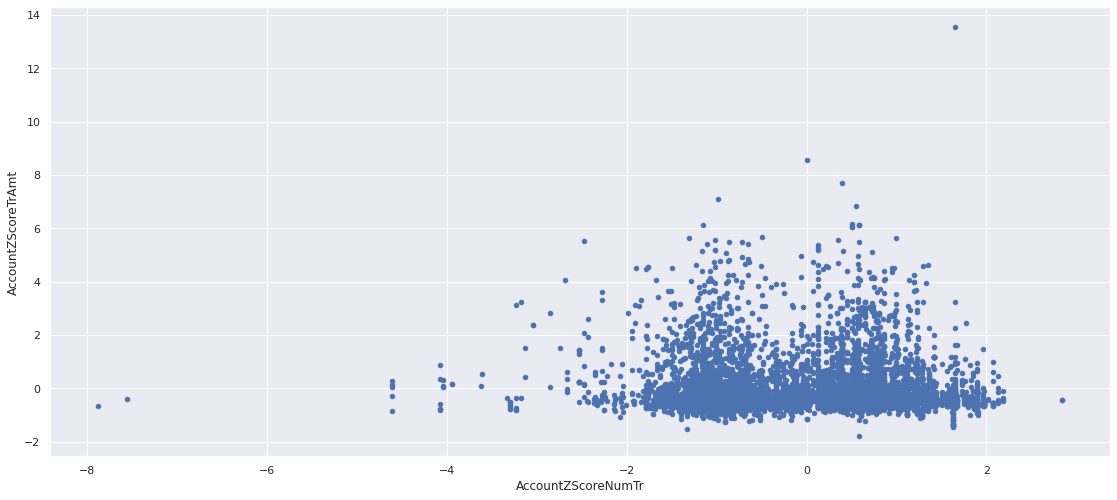

In [ ]:
# create plot of transaction amount over number of transactions for an account
ax1 = df_anomolies.plot.scatter(y='AccountZScoreTrAmt', x='AccountZScoreNumTr')

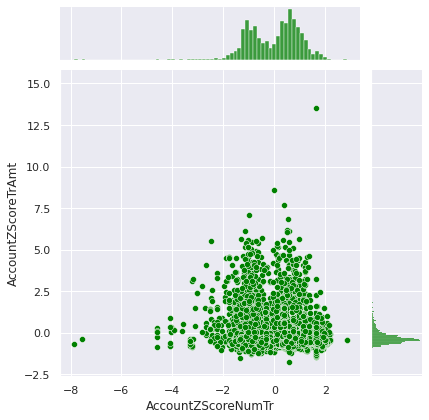

In [ ]:
sns.jointplot(data=df_anomolies, x="AccountZScoreNumTr", y="AccountZScoreTrAmt", color='green')

In [ ]:
# decide normality
topCutOff = 3
bottomCutOff = -3

df_anomolies.loc[df_anomolies["AccountZScoreTrAmt"] > topCutOff, "AcctZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["AccountZScoreTrAmt"] < bottomCutOff, "AcctZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["AccountZScoreNumTr"] > topCutOff, "AcctZAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["AccountZScoreNumTr"] < bottomCutOff, "AcctZAssign"] = 'Abnormal'

df_anomolies.loc[df_anomolies["AcctZAssign"].isnull(), "AcctZAssign"] = 'Normal'

print("Number of records marked as abnormal: ", df_anomolies[df_anomolies["AcctZAssign"] == 'Abnormal'].count()[1])
print("Number of records marked as normal: ", df_anomolies[df_anomolies["AcctZAssign"] == 'Normal'].count()[1])

Number of records marked as abnormal:  468
Number of records marked as normal:  17183


In [ ]:
# remove testing columns
col_drop = ['AcctMean', 'AcctStDev',
       'CountPerAcctOfTransPerMerch', 'TotalTransPerMerch',
       'CountPerAcctStDev', 'MeanPerAcctStDev']

# , 'AccountZScoreTrAmt', 'AccountZScoreNumTr'

df_anomolies = drop_other_cols(df_anomolies, col_drop)

# for testing
df_anomoliesCopy2 = df_anomolies.copy()

In [ ]:
df_anomolies = df_anomoliesCopy2

In [ ]:
df_anomolies

Output hidden; open in https://colab.research.google.com to view.

Isolation Forest

In [ ]:
# Unsupervised model to identify normal vs. abnormal
from sklearn.ensemble import IsolationForest

# create temp output columns
df_anomolies["IsolationFst"] = ""

random_state = np.random.RandomState(42)
model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=random_state)
model.fit(df_anomolies[["FIN.TRANSACTION AMOUNT", "Account (cleansed)"]])
print(model.get_params())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


{'bootstrap': False, 'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7FAF220BB8D0, 'verbose': 0, 'warm_start': False}


In [ ]:
df_anomolies['scores'] = model.decision_function(df_anomolies[["FIN.TRANSACTION AMOUNT", "Account (cleansed)"]])

df_anomolies['anomaly_score'] = model.predict(df_anomolies[["FIN.TRANSACTION AMOUNT", "Account (cleansed)"]])
df_anomolies[df_anomolies['anomaly_score']==-1]

df_anomolies.loc[df_anomolies["anomaly_score"] == -1, "IsolationFst"] = 'Abnormal'
df_anomolies.loc[df_anomolies["anomaly_score"] != -1, "IsolationFst"] = 'Normal'

print("Number of records marked as abnormal: ", df_anomolies[df_anomolies["IsolationFst"] == 'Abnormal'].count()[1])
print("Number of records marked as normal: ", df_anomolies[df_anomolies["IsolationFst"] == 'Normal'].count()[1])

Number of records marked as abnormal:  3534
Number of records marked as normal:  14117


In [ ]:
# remove testing columns
col_drop = ['scores', 'anomaly_score']

df_anomolies = drop_other_cols(df_anomolies, col_drop)

Summary and Assignment of Normality



In [ ]:
# decide if the row should be normal or abnormal

# create assigned value
df_anomolies["NormalityAssign"] = ""
df_anomolies[['Account (cleansed)', 'MCH.MERCHANT NAME', 'FIN.TRANSACTION AMOUNT',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1', 'Employee ID (cleansed)', 'EmpIDZAssign', 'MchZAssign', 'AcctZAssign', 'IsolationFst', 'NormalityAssign']]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# show where all 3 assignments are abnormal
df_anomolies[(df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal")]

Account (cleansed)       MCH.MERCHANT NAME  FIN.TRANSACTION AMOUNT  \
240                  1231  DBC*BLICK ART MATERIAL                 1668.70   
259                  1155             KANOPY INC.                 1267.50   
529                  1066  HY-VEE ROCK ISLAND 154                 4597.80   
738                  1267    ZOOM.US 888-799-9666                 1199.64   
1741                 1155                   EBSCO                 2466.15   
1825                 1278   QUAD CITY TENNIS CLUB                  966.00   
1912                 1126       MENARDS MOLINE IL                 1141.37   
2017                 1267    ZOOM.US 888-799-9666                 1199.64   
2287                 1098  HANDY TRUE VALUE HARDW                  732.48   
2324                 1200       MENARDS MOLINE IL                 1700.31   
2854                 1278   QUAD CITY TENNIS CLUB                 1080.00   
2928                 1278   QUAD CITY TENNIS CLUB                 1260.00   
3136                 1098  HANDY TRUE VALUE HARDW                  813.96   
4455                 1037          RI CITY HALL 5                  207.80   
4528                 1328   ENTERPRISE RENT-A-CAR                 1330.28   
4724                 1351              1680 3E CO                  987.98   
4939                 1154         JEWEL OSCO 0122                  914.46   
5228                 1095      SOUTHWEST AIRLINES                 1100.00   
5232                 1095      SOUTHWEST AIRLINES                 1100.00   
5478                 1279     SUMMIT GRAPHICS INC                 3486.70   
5792                 1062                GRAINGER                 2044.00   
5793                 1062                GRAINGER                 1934.00   
5842                 1095      SOUTHWEST AIRLINES                 1100.00   
5937                 1135    TRUGREEN    *LOCKBOX                 2381.00   
6197                 1351   CRESCENT ELECTRIC 003                  880.58   
7049                 1062    PRAXAIR DIST INC OAM                 2146.48   
7806                 1072      SOUTHWEST AIRLINES                 1100.00   
7995                 1110  CAROLINA BIOLOGIC SUPP                  635.26   
7996                 1110  CAROLINA BIOLOGIC SUPP                  635.26   
8664                 1135    TRUGREEN    *LOCKBOX                 3000.00   
8691                 1063                MARRIOTT                 1077.36   
9648                 1135    TRUGREEN    *LOCKBOX                 2381.00   
9777                 1351              1680 3E CO                 1009.22   
9967                 1025              STRIVESCAN                 1029.15   
10261                1036           LOWES #00104*                  959.96   
11619                1126  SHERWIN WILLIAMS 70324                 1400.00   
11816                1039                 WYNDHAM                 1098.72   
11851                1135                GRAINGER                 3021.40   
12694                1078  HY-VEE ROCK ISLAND 154                  741.00   
13232                1025   ENTERPRISE RENT-A-CAR                 1016.25   
13662                1135  REPUBLIC SERVICES TRAS                 4857.81   
14195                1174                  HILTON                13665.10   
14295                1338  BEST BUY      00000224                 1636.01   
14403                1335            COMFORT INNS                 1900.00   
14816                1036        HOBBY-LOBBY #535                  894.30   
15246                1228      HY-VEE MOLINE 1418                 1081.64   
15554                1351   CRESCENT ELECTRIC 003                  683.28   
15563                1316      SOUTHWEST AIRLINES                 1650.00   
15668                1139            APPLE.COM/US                 1399.00   
15860                1035    WM SUPERCENTER #2231                  643.87   
15870                1280     BEST WESTERN HOTELS                  981.00   
158

In [ ]:
# show where all 3 assignments and isolation forest assignment are abnormal
df_anomolies[(df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal") & (df_anomolies['IsolationFst'] == "Abnormal")]

Account (cleansed)       MCH.MERCHANT NAME  FIN.TRANSACTION AMOUNT  \
240                  1231  DBC*BLICK ART MATERIAL                 1668.70   
259                  1155             KANOPY INC.                 1267.50   
529                  1066  HY-VEE ROCK ISLAND 154                 4597.80   
738                  1267    ZOOM.US 888-799-9666                 1199.64   
1741                 1155                   EBSCO                 2466.15   
1825                 1278   QUAD CITY TENNIS CLUB                  966.00   
1912                 1126       MENARDS MOLINE IL                 1141.37   
2017                 1267    ZOOM.US 888-799-9666                 1199.64   
2287                 1098  HANDY TRUE VALUE HARDW                  732.48   
2324                 1200       MENARDS MOLINE IL                 1700.31   
2854                 1278   QUAD CITY TENNIS CLUB                 1080.00   
2928                 1278   QUAD CITY TENNIS CLUB                 1260.00   
3136                 1098  HANDY TRUE VALUE HARDW                  813.96   
4528                 1328   ENTERPRISE RENT-A-CAR                 1330.28   
4724                 1351              1680 3E CO                  987.98   
4939                 1154         JEWEL OSCO 0122                  914.46   
5228                 1095      SOUTHWEST AIRLINES                 1100.00   
5232                 1095      SOUTHWEST AIRLINES                 1100.00   
5478                 1279     SUMMIT GRAPHICS INC                 3486.70   
5792                 1062                GRAINGER                 2044.00   
5793                 1062                GRAINGER                 1934.00   
5842                 1095      SOUTHWEST AIRLINES                 1100.00   
5937                 1135    TRUGREEN    *LOCKBOX                 2381.00   
6197                 1351   CRESCENT ELECTRIC 003                  880.58   
7049                 1062    PRAXAIR DIST INC OAM                 2146.48   
7806                 1072      SOUTHWEST AIRLINES                 1100.00   
7995                 1110  CAROLINA BIOLOGIC SUPP                  635.26   
7996                 1110  CAROLINA BIOLOGIC SUPP                  635.26   
8664                 1135    TRUGREEN    *LOCKBOX                 3000.00   
8691                 1063                MARRIOTT                 1077.36   
9648                 1135    TRUGREEN    *LOCKBOX                 2381.00   
9777                 1351              1680 3E CO                 1009.22   
9967                 1025              STRIVESCAN                 1029.15   
10261                1036           LOWES #00104*                  959.96   
11619                1126  SHERWIN WILLIAMS 70324                 1400.00   
11816                1039                 WYNDHAM                 1098.72   
11851                1135                GRAINGER                 3021.40   
12694                1078  HY-VEE ROCK ISLAND 154                  741.00   
13232                1025   ENTERPRISE RENT-A-CAR                 1016.25   
13662                1135  REPUBLIC SERVICES TRAS                 4857.81   
14195                1174                  HILTON                13665.10   
14295                1338  BEST BUY      00000224                 1636.01   
14403                1335            COMFORT INNS                 1900.00   
14816                1036        HOBBY-LOBBY #535                  894.30   
15246                1228      HY-VEE MOLINE 1418                 1081.64   
15554                1351   CRESCENT ELECTRIC 003                  683.28   
15563                1316      SOUTHWEST AIRLINES                 1650.00   
15668                1139            APPLE.COM/US                 1399.00   
15860                1035    WM SUPERCENTER #2231                  643.87   
15870                1280     BEST WESTERN HOTELS                  981.00   
15871                1280     BEST WESTERN HOTELS                  981.00   
170

In [ ]:
# show where all 2 of the 3 assignments are abnormal
df_model2of3 = df_anomolies[((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['MchZAssign'] == "Abnormal")) | 
             ((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal")) | 
             ((df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal"))]
df_model2of3

Account (cleansed)       MCH.MERCHANT NAME  FIN.TRANSACTION AMOUNT  \
69                   1037          RI CITY HALL 5                  163.80   
91                   1159          LEISUREPRO.COM                 2234.54   
94                   1343       WRIGHTS MEDIA LLC                 1850.00   
240                  1231  DBC*BLICK ART MATERIAL                 1668.70   
259                  1155             KANOPY INC.                 1267.50   
...                   ...                     ...                     ...   
17463                1127   REXCO EQUIP DAVENPORT                 1054.90   
17517                1312            CHICAGO CUBS                10429.44   
17551                1299          EMBASSY SUITES                 1200.00   
17559                1061           TECHNOLUTIONS                  495.00   
17598                1202  IN *ASSOCIATED CONTROL                  495.02   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1 FIN.TRANSACTION DATE  \
69                                      PUBLIC SAFETY           01/06/2021   
91                                            GEOLOGY           12/31/2020   
94                           OFFICE OF COMMUNICATIONS           01/04/2021   
240                                        ART STUDIO           01/12/2021   
259                                           LIBRARY           01/11/2021   
...                                               ...                  ...   
17463                             FACILITIES SERVICES           12/20/2021   
17517                                     ADVANCEMENT           12/21/2021   
17551                                       ATHLETICS           12/21/2021   
17559                                     ADVANCEMENT           12/22/2021   
17598                             FACILITIES SERVICES           12/23/2021   

      Employee ID (cleansed)  EmpIDZScoreTrAmt  EmpIDZScoreNumTr EmpIDZAssign  \
69                    Emp706          0.091834         -4.043786     Abnormal   
91                    Emp969          5.280701               NaN     Abnormal   
94                    Emp979          3.695837               NaN     Abnormal   
240                   Emp782          3.788642          0.068343     Abnormal   
259                   Emp820          3.476300               NaN     Abnormal   
...                      ...               ...               ...          ...   
17463                 Emp788          3.623565          0.377964     Abnormal   
17517                 Emp842          6.659047         -1.154701     Abnormal   
17551                 Emp973          3.787144         -0.390137     Abnormal   
17559                 Emp841          4.483302         -1.788854     Abnormal   
17598                 Emp823          3.824140               NaN     Abnormal   

       MerchZScoreTrAmt  MerchZScoreNumTr MchZAssign  AccountZScoreTrAmt  \
69             2.837789          0.106412     Normal            0.091834   
91             1.498547         -0.437178     Normal            5.280701   
94                  NaN         -0.470459     Normal            3.695837   
240            3.024900         -0.015619   Abnormal            3.788642   
259            3.894215         -0.115462   Abnormal            3.476300   
...                 ...               ...        ...                 ...   
17463          1.108285         -0.403897     Normal            3.623565   
17517          1.143451         -0.448272     Normal            6.112907   
17551          2.051392         -0.381710     Normal            3.787144   
17559         -1.095445         -0.426085     Normal            4.483302   
17598         -0.121159         -0.437178     Normal            3.101457   

       AccountZScoreNumTr AcctZAssign IsolationFst NormalityAssign  
69              -4.043786    Abnormal       Normal                  
91                    NaN    Abnormal     Abnormal                  
94                    NaN    Abnormal     Abnormal  

In [ ]:
# show where 2/3 are abnormal and also isolation forest is abnormal
df_anomolies[((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['IsolationFst'] == "Abnormal")) | 
             ((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal") & (df_anomolies['IsolationFst'] == "Abnormal")) | 
             ((df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal") & (df_anomolies['IsolationFst'] == "Abnormal"))]

Account (cleansed)       MCH.MERCHANT NAME  FIN.TRANSACTION AMOUNT  \
91                   1159          LEISUREPRO.COM                 2234.54   
94                   1343       WRIGHTS MEDIA LLC                 1850.00   
240                  1231  DBC*BLICK ART MATERIAL                 1668.70   
259                  1155             KANOPY INC.                 1267.50   
265                  1155             UCLA ONLINE                 1785.00   
...                   ...                     ...                     ...   
17463                1127   REXCO EQUIP DAVENPORT                 1054.90   
17517                1312            CHICAGO CUBS                10429.44   
17551                1299          EMBASSY SUITES                 1200.00   
17559                1061           TECHNOLUTIONS                  495.00   
17598                1202  IN *ASSOCIATED CONTROL                  495.02   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1 FIN.TRANSACTION DATE  \
91                                            GEOLOGY           12/31/2020   
94                           OFFICE OF COMMUNICATIONS           01/04/2021   
240                                        ART STUDIO           01/12/2021   
259                                           LIBRARY           01/11/2021   
265                                           LIBRARY           01/11/2021   
...                                               ...                  ...   
17463                             FACILITIES SERVICES           12/20/2021   
17517                                     ADVANCEMENT           12/21/2021   
17551                                       ATHLETICS           12/21/2021   
17559                                     ADVANCEMENT           12/22/2021   
17598                             FACILITIES SERVICES           12/23/2021   

      Employee ID (cleansed)  EmpIDZScoreTrAmt  EmpIDZScoreNumTr EmpIDZAssign  \
91                    Emp969          5.280701               NaN     Abnormal   
94                    Emp979          3.695837               NaN     Abnormal   
240                   Emp782          3.788642          0.068343     Abnormal   
259                   Emp820          3.476300               NaN     Abnormal   
265                   Emp820          5.108971               NaN     Abnormal   
...                      ...               ...               ...          ...   
17463                 Emp788          3.623565          0.377964     Abnormal   
17517                 Emp842          6.659047         -1.154701     Abnormal   
17551                 Emp973          3.787144         -0.390137     Abnormal   
17559                 Emp841          4.483302         -1.788854     Abnormal   
17598                 Emp823          3.824140               NaN     Abnormal   

       MerchZScoreTrAmt  MerchZScoreNumTr MchZAssign  AccountZScoreTrAmt  \
91             1.498547         -0.437178     Normal            5.280701   
94                  NaN         -0.470459     Normal            3.695837   
240            3.024900         -0.015619   Abnormal            3.788642   
259            3.894215         -0.115462   Abnormal            3.476300   
265                 NaN         -0.470459     Normal            5.108971   
...                 ...               ...        ...                 ...   
17463          1.108285         -0.403897     Normal            3.623565   
17517          1.143451         -0.448272     Normal            6.112907   
17551          2.051392         -0.381710     Normal            3.787144   
17559         -1.095445         -0.426085     Normal            4.483302   
17598         -0.121159         -0.437178     Normal            3.101457   

       AccountZScoreNumTr AcctZAssign IsolationFst NormalityAssign  
91                    NaN    Abnormal     Abnormal                  
94                    NaN    Abnormal     Abnormal                  
240              0.750372    Abnormal     Abnormal  

In [ ]:
# show where each transaction contains at least one abnormal
df_anomolies[((df_anomolies['EmpIDZAssign'] == "Abnormal") | (df_anomolies['AcctZAssign'] == "Abnormal") | (df_anomolies['MchZAssign'] == "Abnormal"))]

Account (cleansed)       MCH.MERCHANT NAME  FIN.TRANSACTION AMOUNT  \
31                   1098  HANDY TRUE VALUE HARDW                   11.01   
34                   1155             KANOPY INC.                 1087.50   
41                   1157  HANDY TRUE VALUE HARDW                   54.25   
69                   1037          RI CITY HALL 5                  163.80   
87                   1157  HANDY TRUE VALUE HARDW                   83.07   
...                   ...                     ...                     ...   
17598                1202  IN *ASSOCIATED CONTROL                  495.02   
17601                1066  HY-VEE ROCK ISLAND 154                  112.71   
17628                1097  HY-VEE ROCK ISLAND 154                    5.41   
17651                1202  HANDY TRUE VALUE HARDW                    9.46   
17653                1268         COMCAST CHICAGO                   91.90   

      ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1 FIN.TRANSACTION DATE  \
31                                FACILITIES SERVICES           01/04/2021   
34                                            LIBRARY           01/04/2021   
41                                FACILITIES SERVICES           01/04/2021   
69                                      PUBLIC SAFETY           01/06/2021   
87                                FACILITIES SERVICES           01/05/2021   
...                                               ...                  ...   
17598                             FACILITIES SERVICES           12/23/2021   
17601                   INTN'L STU & SCHOLAR SERVICES           12/24/2021   
17628                             FACILITIES SERVICES           12/26/2021   
17651                             FACILITIES SERVICES           12/27/2021   
17653                                      ADMISSIONS           12/29/2021   

      Employee ID (cleansed)  EmpIDZScoreTrAmt  EmpIDZScoreNumTr EmpIDZAssign  \
31                    Emp707         -0.694916         -0.519655       Normal   
34                    Emp820          2.908414               NaN       Normal   
41                    Emp823         -0.496100         -0.388070       Normal   
69                    Emp706          0.091834         -4.043786     Abnormal   
87                    Emp823         -0.213619         -0.388070       Normal   
...                      ...               ...               ...          ...   
17598                 Emp823          3.824140               NaN     Abnormal   
17601                Emp1005         -0.018444          1.401189       Normal   
17628                 Emp704         -0.743633         -1.118058       Normal   
17651                 Emp823         -0.935113         -0.388070       Normal   
17653                 Emp913         -0.050635               NaN       Normal   

       MerchZScoreTrAmt  MerchZScoreNumTr MchZAssign  AccountZScoreTrAmt  \
31            -0.299410          3.667480   Abnormal           -0.694916   
34             3.195427         -0.115462   Abnormal            2.908414   
41             0.412961          3.667480   Abnormal           -0.475661   
69             2.837789          0.106412     Normal            0.091834   
87             0.887764          3.667480   Abnormal           -0.167052   
...                 ...               ...        ...                 ...   
17598         -0.121159         -0.437178     Normal            3.101457   
17601          0.213559          4.222164   Abnormal           -0.018444   
17628         -0.246706          4.222164   Abnormal           -0.743633   
17651         -0.324946          3.667480   Abnormal           -0.891017   
17653          3.328201         -0.337335   Abnormal           -0.102715   

       AccountZScoreNumTr AcctZAssign IsolationFst NormalityAssign  
31              -0.490276      Normal       Normal                  
34                    NaN      Normal     Abnormal                  
41              -0.554977      Normal       Normal  

Assign Normality

In [ ]:
# assign abnormal where 2 out of 3 z score tests were abnormal
df_anomolies.loc[((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['MchZAssign'] == "Abnormal")), "NormalityAssign"] = 'Abnormal'
df_anomolies.loc[((df_anomolies['EmpIDZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal")), "NormalityAssign"] = 'Abnormal'
df_anomolies.loc[((df_anomolies['MchZAssign'] == "Abnormal") & (df_anomolies['AcctZAssign'] == "Abnormal")), "NormalityAssign"] = 'Abnormal'
df_anomolies.loc[df_anomolies["NormalityAssign"] == "", "NormalityAssign"] = 'Normal'

print("Number of records marked as abnormal: ", df_anomolies[df_anomolies["NormalityAssign"] == 'Abnormal'].count()[1])
print("Number of records marked as normal: ", df_anomolies[df_anomolies["NormalityAssign"] == 'Normal'].count()[1])

Number of records marked as abnormal:  460
Number of records marked as normal:  17191


Employees that have most Abnormal Transactions

In [ ]:
mostAbEmp = pd.DataFrame()
temp = df_anomolies[df_anomolies['NormalityAssign'] == 'Abnormal']
mostAbEmp["CountOfAbnormalTransactions"] = temp.groupby("Employee ID (cleansed)").count()["NormalityAssign"]

temp = df_anomolies.groupby("Employee ID (cleansed)").count()
mostAbEmp["EmpTotalCountofTransactions"] = df_anomolies.groupby('Employee ID (cleansed)').count()["FIN.TRANSACTION AMOUNT"]

mostAbEmp

CountOfAbnormalTransactions  \
Employee ID (cleansed)                                
Emp1000                                           1   
Emp1003                                           2   
Emp1005                                           1   
Emp1007                                           4   
Emp1009                                           1   
...                                             ...   
Emp989                                            1   
Emp992                                            2   
Emp994                                            2   
Emp996                                            8   
Emp998                                            1   

                        EmpTotalCountofTransactions  
Employee ID (cleansed)                               
Emp1000                                          17  
Emp1003                                          58  
Emp1005                                         227  
Emp1007                                         149  
Emp1009                                          42  
...                                             ...  
Emp989                                           13  
Emp992                                           63  
Emp994                                           82  
Emp996                                          105  
Emp998                                           23  

[184 rows x 2 columns]

In [ ]:
mostAbEmp.columns

Index(['CountOfAbnormalTransactions', 'EmpTotalCountofTransactions'], dtype='object')

In [ ]:
sns.set(rc={'figure.figsize':(29,8.27)})
sns.barplot(x=mostAbEmp.index.values, y=mostAbEmp["CountOfAbnormalTransactions"])
plt.title('Abnormal Transaction Distribution per Employee')
plt.xlabel('Employee ID')
plt.ylabel('Count')
plt.xticks(rotation=75, fontsize=8)
plt.show()

# Building a Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import r2_score

In [ ]:
# What is your goal? Normal vs. abnormal detection in this dataset

In [ ]:
print(f'The filtered dataset has {df_anomolies.shape[0]} records and {df_anomolies.shape[1]} features.')

The filtered dataset has 17688 records and 17 features.


Clean Data for Modeling

In [ ]:
# set abnormal = 1 and normal =1 for NormalityAssign.
df_anomolies.loc[df_anomolies["NormalityAssign"] == "Normal", "NormalityAssign"] = 0
df_anomolies.loc[df_anomolies["NormalityAssign"] == "Abnormal", "NormalityAssign"] = 1

In [ ]:
# fix employee ID to get rid of Emp
df_anomolies["Employee ID (cleansed)"] = df_anomolies["Employee ID (cleansed)"].str[3:]

Drop Columns

In [ ]:
df_anomolies.columns

Index(['Account (cleansed)', 'MCH.MERCHANT NAME', 'FIN.TRANSACTION AMOUNT',
       'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1',
       'FIN.TRANSACTION DATE', 'Employee ID (cleansed)', 'EmpIDZScoreTrAmt',
       'EmpIDZScoreNumTr', 'EmpIDZAssign', 'MerchZScoreTrAmt',
       'MerchZScoreNumTr', 'MchZAssign', 'AccountZScoreTrAmt',
       'AccountZScoreNumTr', 'AcctZAssign', 'IsolationFst', 'NormalityAssign'],
      dtype='object')

In [ ]:
# drop columns that are not needed for modelling
# data frame including z score columns
col_drop = ['MCH.MERCHANT NAME', 'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1', 'FIN.TRANSACTION DATE', 'EmpIDZAssign', 'MchZAssign', 'AcctZAssign', 'IsolationFst']
df_modelingZScore = df_anomolies.drop(columns=col_drop)

# data frame excluding z score columns
col_drop = ['MCH.MERCHANT NAME', 'ACC.REPORTS TO INTERMEDIATE LEVEL 1 NAME LINE 1', 'FIN.TRANSACTION DATE', 'EmpIDZScoreTrAmt',
       'EmpIDZScoreNumTr', 'EmpIDZAssign', 'MerchZScoreTrAmt',
       'MerchZScoreNumTr', 'MchZAssign', 'AccountZScoreTrAmt',
       'AccountZScoreNumTr', 'AcctZAssign', 'IsolationFst']
df_modelingNoZScore = df_anomolies.drop(columns=col_drop)

In [ ]:
# not really enough features to warrant a chi squared test

Double Check Data is Ready

In [ ]:
df_modelingZScore

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Nearly half of the abnormal records would need to be dropped in order to do logistic regression, we will only use the other dataset
test = df_modelingZScore[df_modelingZScore.isnull().any(axis=1)]
test[test["NormalityAssign"] == 1]

Account (cleansed)  FIN.TRANSACTION AMOUNT Employee ID (cleansed)  \
91                   1159                 2234.54                    969   
94                   1343                 1850.00                    979   
259                  1155                 1267.50                    820   
265                  1155                 1785.00                    820   
349                  1196                 7250.00                    864   
...                   ...                     ...                    ...   
17101                1254                 2427.98                    804   
17410                1178                 2202.84                    780   
17447                1230                 5287.00                    740   
17458                1102                 1389.00                    714   
17598                1202                  495.02                    823   

       EmpIDZScoreTrAmt  EmpIDZScoreNumTr  MerchZScoreTrAmt  MerchZScoreNumTr  \
91             5.280701               NaN          1.498547         -0.437178   
94             3.695837               NaN               NaN         -0.470459   
259            3.476300               NaN          3.894215         -0.115462   
265            5.108971               NaN               NaN         -0.470459   
349            9.777392               NaN               NaN         -0.470459   
...                 ...               ...               ...               ...   
17101          4.073268               NaN          2.141173         -0.337335   
17410          3.437896               NaN               NaN         -0.470459   
17447          7.849740               NaN               NaN         -0.470459   
17458          3.352945               NaN          1.057973         -0.193118   
17598          3.824140               NaN         -0.121159         -0.437178   

       AccountZScoreTrAmt  AccountZScoreNumTr NormalityAssign  
91               5.280701                 NaN               1  
94               3.695837                 NaN               1  
259              3.476300                 NaN               1  
265              5.108971                 NaN               1  
349              9.777392                 NaN               1  
...                   ...                 ...             ...  
17101            4.073268                 NaN               1  
17410            3.437896                 NaN               1  
17447            3.422503                 NaN               1  
17458            3.352945                 NaN               1  
17598            3.101457           -0.866025               1  

[244 rows x 10 columns]

In [ ]:
df_modelingNoZScore

Output hidden; open in https://colab.research.google.com to view.

Check Data Types

In [ ]:
df_modelingNoZScore.dtypes

Account (cleansed)          int64
FIN.TRANSACTION AMOUNT    float64
Employee ID (cleansed)     object
NormalityAssign            object
dtype: object

In [ ]:
# need to make "FIN.TRANSACTION AMOUNT" an int
df_modelingNoZScore["FIN.TRANSACTION AMOUNT"] = df_modelingNoZScore["FIN.TRANSACTION AMOUNT"].astype('int')

Functions to print Error Analysis

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report

In [ ]:
# plots confusion matrix of multiple models
def plot_conf_mat(models,X,y,label):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    fig.suptitle(f'Confusion Matrix - {label}',fontsize=16)

    for model, ax in zip(models, axes.flatten()):
        estimator = models[str(model)]

        plot_confusion_matrix(estimator, 
                              X, 
                              y, 
                              ax=ax, 
                              cmap='Blues',
                              normalize= 'all',
                              values_format = '.2f',
                              display_labels=list(estimator.classes_))
        ax.title.set_text(type(estimator).__name__)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
    plt.show()

In [ ]:
# plots the classification report of multiple models
def classif_report(models,X_test,y_test):
    for model in models:

        estimator = models[str(model)]
        y_pred = models[str(model)].predict(X_test)
        report = classification_report(y_test,y_pred,
                                       output_dict=True,
                                       target_names=list(estimator.classes_))
        clsf_report = pd.DataFrame(report).transpose()
        print(model+ '\n' + str(clsf_report) + '\n')

In [ ]:
# shows accuracy scores of multiple models
def accuracy_score_models(models,X_test):
    for model in models:
        estimator = models[str(model)]
        y_pred = estimator.predict(X_test)
        print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),3))

# Model With NoZScore data

Split into Test and Training Sets

In [ ]:
# df_modelingNoZScore

targetCol = 'NormalityAssign'

# define the target 
target = pd.DataFrame(df_modelingNoZScore[targetCol], columns=[targetCol])

# define the features
features = df_modelingNoZScore.drop(labels=[targetCol], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=50)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

Build the model

In [ ]:
models = {}

In [ ]:
# logistic regression
%%time
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver = 'lbfgs', n_jobs=-1, max_iter=350, random_state=0)
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 49.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# random forest
%%time
from sklearn.ensemble import RandomForestClassifier

randomf = RandomForestClassifier(random_state = 0, bootstrap = True,   criterion = "gini", min_samples_leaf = 45, 
                                 max_features = 3, max_depth = 30,min_samples_split = 45, n_estimators = 40,
                                 n_jobs = -1)
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 666 ms, sys: 7.71 ms, total: 673 ms
Wall time: 427 ms


Evaluation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


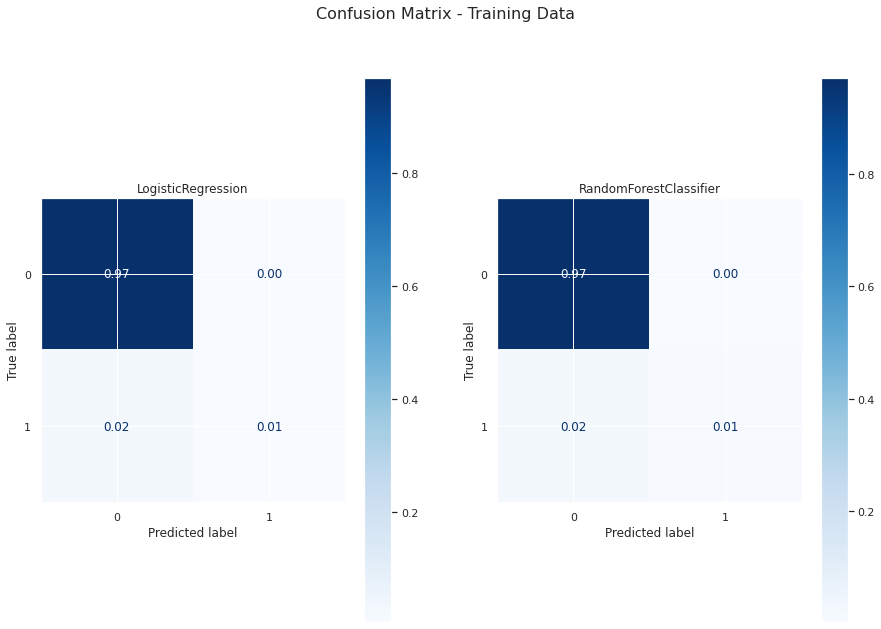

In [ ]:
plot_conf_mat(models,X_train,y_train,label='Training Data')

In [ ]:
plot_conf_mat(models,X_test,y_test,label='Validation Data')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
classif_report(models,X_test,y_test)

LogisticRegression
              precision    recall  f1-score      support
0              0.981780  0.994201  0.987952  5691.000000
1              0.560000  0.285714  0.378378   147.000000
accuracy       0.976362  0.976362  0.976362     0.976362
macro avg      0.770890  0.639958  0.683165  5838.000000
weighted avg   0.971160  0.976362  0.972603  5838.000000

RandomForestClassifier
              precision    recall  f1-score      support
0              0.982836  0.996134  0.989441  5691.000000
1              0.685714  0.326531  0.442396   147.000000
accuracy       0.979274  0.979274  0.979274     0.979274
macro avg      0.834275  0.661332  0.715918  5838.000000
weighted avg   0.975355  0.979274  0.975666  5838.000000



In [ ]:
accuracy_score_models(models,X_test)

LogisticRegression 0.976
RandomForestClassifier 0.979


# Deployment and Pipeline

In [ ]:
# Augustana should create a transaction dashboard (similar to the tables generated in this report) so that they can monitor transactions in real time. 
# They can also then see abnormality detections in real time and investigate them quickly

# This project can serve as the baseline business rules to apply normality assignments to transactions